In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
import logging
# Suppress specific noisy JAX backend logs
logging.getLogger("jax._src.xla_bridge").setLevel(logging.ERROR)
import optax
from eda import *
from preprocessing import *
from pca_utils import *
from diagnostics import *
from model_fitting import *
from core_filter import KalmanFilter, KalmanFilterConfig
from train_filter import KalmanTrainer
import importlib, evaluation
importlib.reload(evaluation)
from evaluation import *

## General Preprocessing & EDA

#### Obtain data:
1. Federal Funds Effective Rate (DFF): unit in percentage (used as control factor instead of background variable in FAVAR framework)
2. Core CPI (CPILFESL): unit in index values
3. Unemployment Rate (UNRATE): unit in percentage
4. Real GDP (GDP): unit in billions of dollars

In [2]:
raw_data_path = 'data/raw'
daily_factors = ['DFF']
monthly_factors = ['CPILFESL','UNRATE']
quarterly_factors = ['GDP']
df = read_data(data_path=raw_data_path, daily_factors=daily_factors, monthly_factors=monthly_factors, quarterly_factors=quarterly_factors)
display(df)

DFF    CPILFESL    UNRATE        GDP
observation_date                                           
1985-04-01        8.475111  107.633333  7.233333   4294.887
1985-07-01        7.924396  108.766667  7.300000   4386.773
1985-10-01        7.900978  109.733333  7.200000   4444.094
1986-01-01        8.104457  111.000000  7.033333   4507.894
1986-04-01        7.826889  112.200000  7.033333   4545.340
...                    ...         ...       ...        ...
2023-10-01        5.259239  309.740333  3.666667  28296.967
2024-01-01        5.330000  312.345333  3.800000  28624.069
2024-04-01        5.330000  315.568667  3.833333  29016.714
2024-07-01        5.330000  317.997333  4.000000  29374.914
2024-10-01        5.264783  319.869000  4.166667  29723.864

[159 rows x 4 columns]

#### Train / Test split:

Use training set for eda & optimizer tuning.

In [3]:
split_date = '2025-01-01'
train_df = df[df.index < split_date]

#### EDA:
1. stationary 
 - Macro level data is highly trending, which will lead to nonstationary initial setups if unresolved. Using level data increases the risk of explosive transition matrix in the state model, which may lead to unbounded gradient variances and explosive gradients.
 - Differencing removes memory and instead models delta_Y, will need post-processing to recover level-wise prediction.
2. structural breaks
 - Structural breaks are visible for policy rate and unemployment rate using simple stats check, but no sharp breaks are present. This may suggest the validity of a long training window size.
3. outliers
 - Outliers for policy rate are more indications of structural breaks. There are indeed outliers around 2008 and Covid for unemployment rate.
4. data distribution
 - Variables are mostly right-skewed except for CPI.

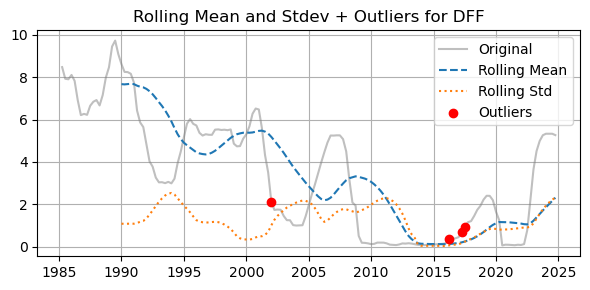

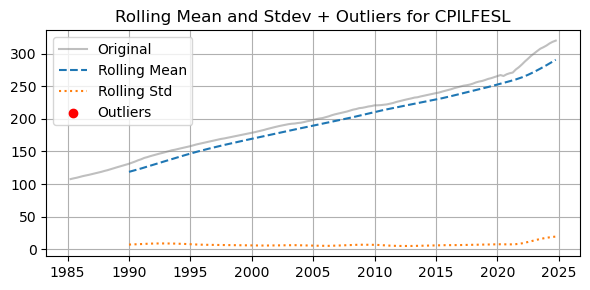

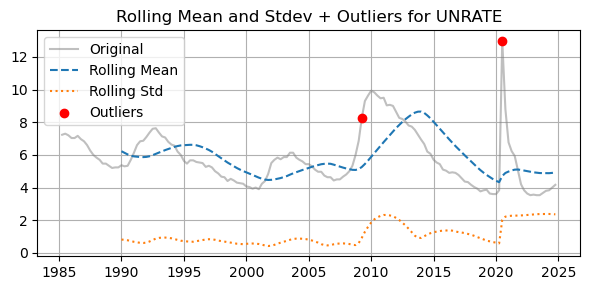

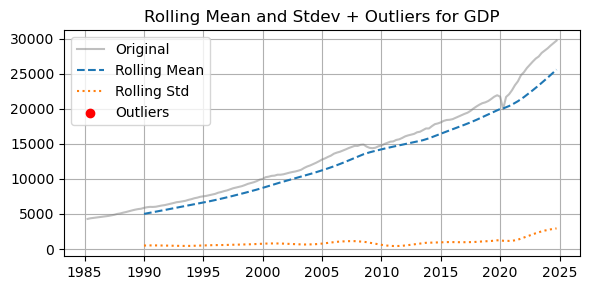

In [4]:
eda(train_df)

In [5]:
adf_train = adf_test_all_features(train_df)
display(adf_train)

Feature  ADF Statistic   p-value Stationary  \
0       DFF      -2.508978  0.113305         No   
1  CPILFESL       1.485930  0.997472         No   
2    UNRATE      -3.355820  0.012560        Yes   
3       GDP       4.508684  1.000000         No   

                                     Critical Values  
0  {'1%': -3.472703119504854, '5%': -2.8801316723...  
1  {'1%': -3.4756368462466662, '5%': -2.881410446...  
2  {'1%': -3.4724305215713156, '5%': -2.880012793...  
3  {'1%': -3.4724305215713156, '5%': -2.880012793...

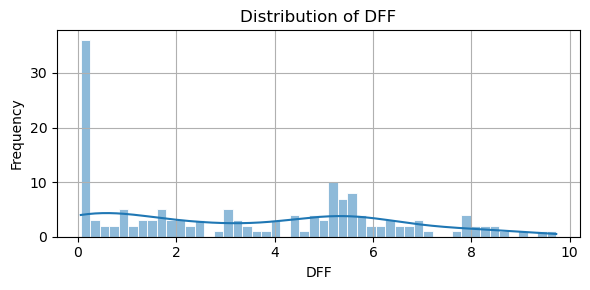

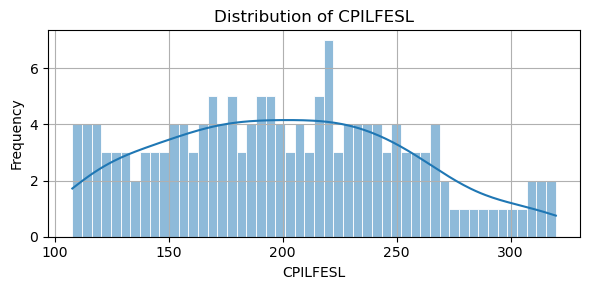

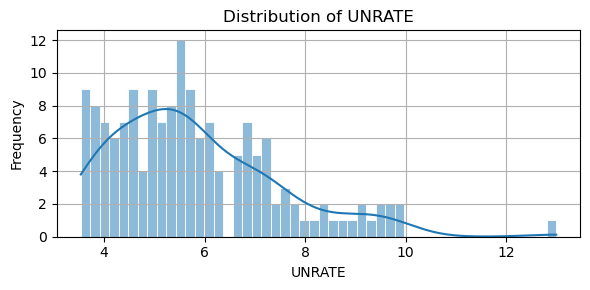

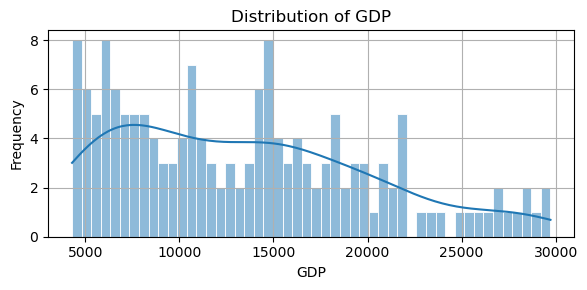

In [6]:
distribution(train_df)

#### Preprocessing:
1. Differencing
 - Log differencing is applied to CPI and GDP.
 - DFF and UNRATE are relatively stationary and kept as level data.
 - If differencing is not ideal, there are alternatives like adding constraints on eignevalues of transition matrix A or applying regularizations to avoid explosive variance.
2. Standardization
 - Standardization to z-score is applied per rolling window to all variables. 
 - PCA and backpropagation are both sensitive to scale.
3. Outlier cap
 - Redundant. The loss function will include the prediction errors triggered by outliers and the information will be passed on to model parameters during back propagation.

Both differencing and standardization can be post-processed to original scale and level. That is, although Kalman filtering and the subsequent loss function are built on the standardized rate scale, we can recover train and test predictions back to original scale and level (although may suffer from cumulative errors). Whether recovering is needed depends on purpose.

After first-order log difference, CPI is still slightly non-stationary. Since its rolling mean and stdev is relatively stable locally, I believe it is stationary within a rolling window method. The non-stationary is likely due to regime shift, so second-order log difference is not necessary.

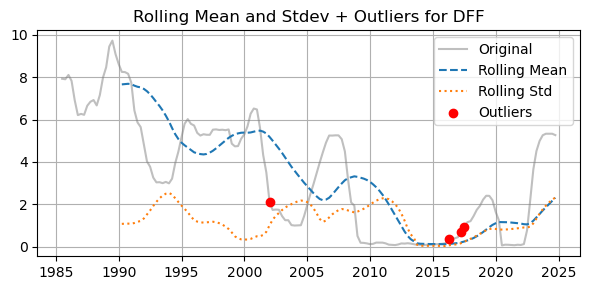

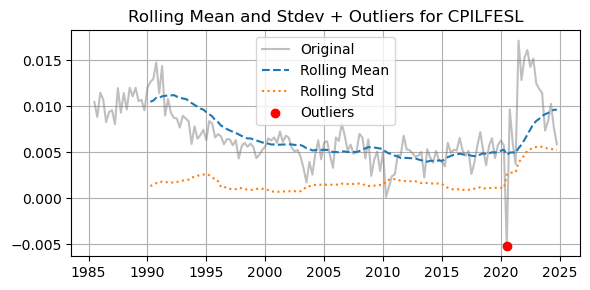

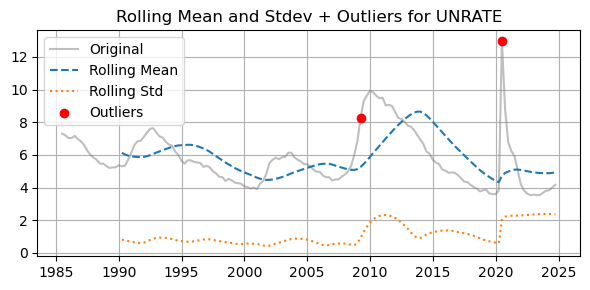

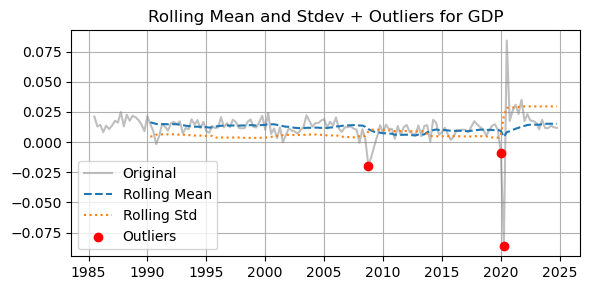

Feature  ADF Statistic       p-value Stationary  \
0       DFF      -2.687085  7.629990e-02         No   
1  CPILFESL      -1.863164  3.495832e-01         No   
2    UNRATE      -3.361385  1.234785e-02        Yes   
3       GDP     -13.000135  2.698099e-24        Yes   

                                     Critical Values  
0  {'1%': -3.4729792729247793, '5%': -2.880252091...  
1  {'1%': -3.4756368462466662, '5%': -2.881410446...  
2  {'1%': -3.472703119504854, '5%': -2.8801316723...  
3  {'1%': -3.472703119504854, '5%': -2.8801316723...

In [4]:
# Differencing is applied to original dataset
log_diff_cols = ['CPILFESL', 'GDP']
diff_cols = []
stationary_df = make_stationary(df, log_diff_cols, diff_cols)

# verify staionary 
train_df_stationary = stationary_df[stationary_df.index < split_date]
eda(train_df_stationary)
display(adf_test_all_features(train_df_stationary))

### Initialization

- Standardization

- Outlier cap by mad per window is turned off

Perform separately on train / test set to avoid look-ahead bias.

2025-05-07 16:17:04,740 - INFO - Standardization complete.


2025-05-07 16:17:04,742 - INFO - Window initialized with size 158. Features: ['DFF', 'CPILFESL', 'UNRATE', 'GDP']


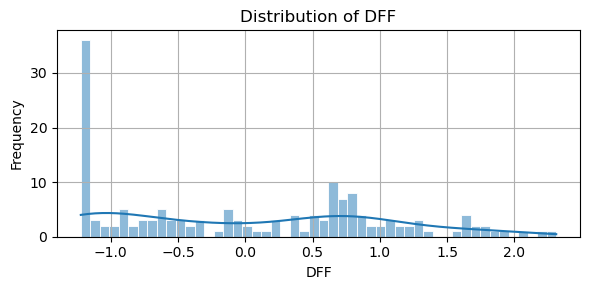

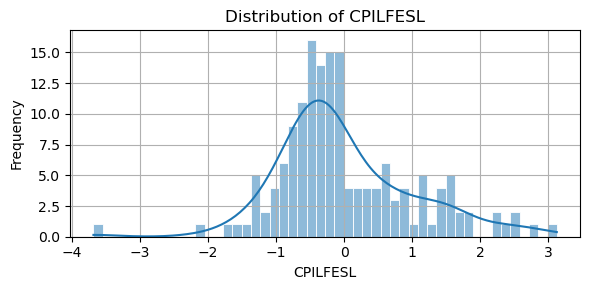

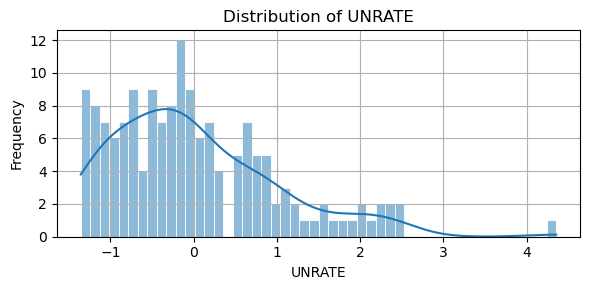

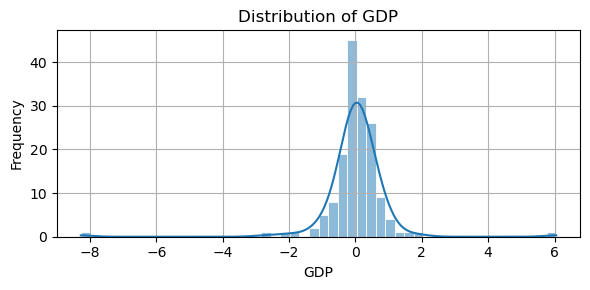

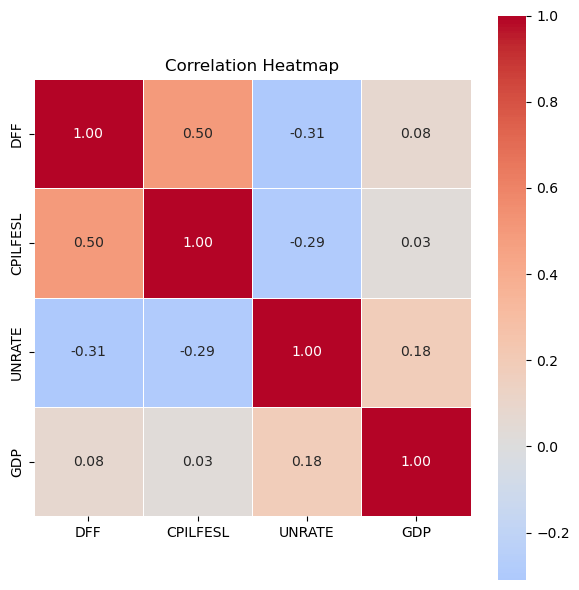

In [5]:
clipping_factors = []
train_df_normalized , train_scaler = initialize_by_window(train_df_stationary, clipping_factors=clipping_factors, window_size = len(train_df_stationary), plot=True)

#### PCA
 - Scree plot to choose latent dimension d
 - Time series plot of top d principal components

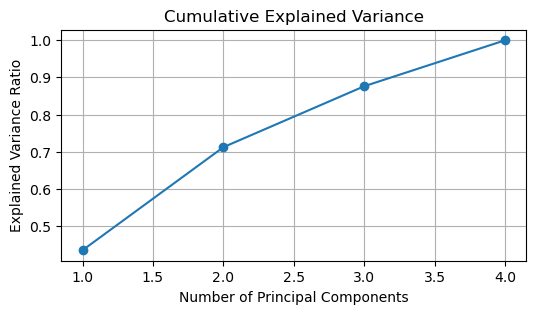

DFF  CPILFESL    UNRATE       GDP
0  0.614926  0.606582 -0.502168 -0.041853
1  0.223534  0.167139  0.402976  0.871612
2  0.156358  0.432259  0.752864 -0.471064
3  0.739899 -0.645969  0.136507 -0.128996

In [22]:
display(scree_plot(train_df_normalized))

There is no elbow present in the scree plot, meaning the variance is evenly spread across features. 

I choose number of components $k$ to be 2 because:
 - The first two components explain ~70% of the variance, which is relatively good.
 - The residuals from projecting onto the PCs lie in the orthogonal complement, meaning the sample covariance matrix $R$ of the residuals has rank at most $n-k$. We need the rank of $R$ not too small to prevent filter collapsing.

Even with differencing on observable data, some of our principal components are still nonstationary.

2025-05-07 16:17:26,962 - INFO - PCA complete. Explained variance ratio: [0.4348 0.2774]


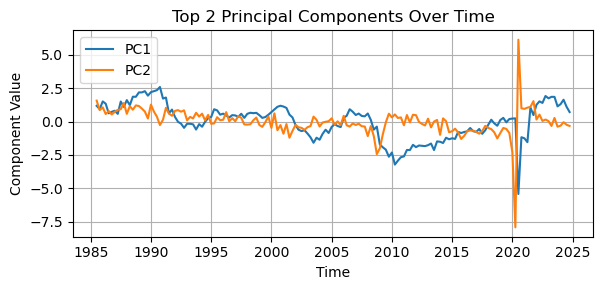

Feature  ADF Statistic   p-value Stationary  \
0     PC1      -2.745247  0.066531         No   
1     PC2      -5.118926  0.000013        Yes   

                                     Critical Values  
0  {'1%': -3.473542528196209, '5%': -2.8804976741...  
1  {'1%': -3.4732590518613002, '5%': -2.880374082...

In [7]:
train_latent_df = pca(train_df_normalized, plot=True)
display(adf_test_all_features(train_latent_df))

From the heatmap of original level-based variables, there is strong correlation coming from shared trends as it greatly shrinks with differencing. 

If we apply above procedure for PCA to level-based data, we can see the first two PCs dominate the explained variance. 

Especially for the first PC, it is simply the upward trend as all variables are trending upward. This shows that shared trends inflate the first principal component. 

And for the second PC, it is dominated by unemployment rate.

Given this observation, I will proceed with the PCs generated after differencing data as they better capture the structural relationship between variables.

2025-05-07 15:49:46,495 - INFO - Standardization complete.
2025-05-07 15:49:46,498 - INFO - Window initialized with size 159. Features: ['DFF', 'CPILFESL', 'UNRATE', 'GDP']
2025-05-07 15:49:46,504 - INFO - PCA complete. Explained variance ratio: [0.6321 0.3055]


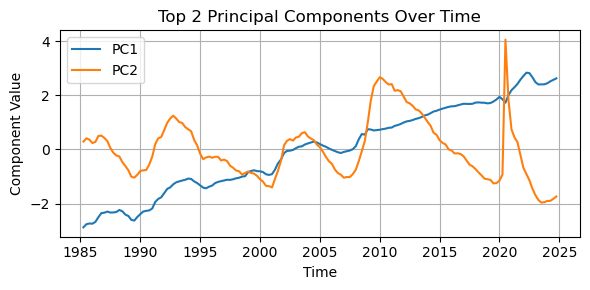

2025-05-07 15:49:46,868 - INFO - PCA complete. Explained variance ratio: [0.6321 0.3055]


Feature  ADF Statistic   p-value Stationary  \
0     PC1      -0.606557  0.869493         No   
1     PC2      -2.566467  0.100128         No   

                                     Critical Values  
0  {'1%': -3.472703119504854, '5%': -2.8801316723...  
1  {'1%': -3.4724305215713156, '5%': -2.880012793...

In [8]:
train_level_df , _ = initialize_by_window(train_df, clipping_factors=clipping_factors, window_size=len(df), plot=False)
pca(train_level_df, plot=True)
display(adf_test_all_features(pca(train_level_df, n_components=2)))

#### VAR

Now we fit VAR(1) to the state space model:
$$
X_t = A X_{t-1} + G \epsilon_t.
$$
where A is the transition matrix.

 - As said before, principal components from relatively stationary time series can still contain autocorrelation.  We inspect eigenvalues of A (should lie inside the unit circle for A to be stable). Instead of applying differencing on PCs again before fitting VAR, I choose to rescale A to shrink its influence to lie inside the unit circle.
- No separate regularization is applied to $Q = \text{Cov}(G \epsilon_t)$ at this stage; all noise structure is handled jointly in the stacked framework.

In [8]:
A, G_epsilon = fit_transition_model(train_latent_df)

2025-05-07 16:17:32,160 - INFO - Fitting VAR(1) model to latent state series with shape (158, 2).


2025-05-07 16:17:32,833 - INFO - VAR coefficients extracted. Projecting A to ensure stability.


### OLS

Now we fit OLS to the observation model:
$$
Y_t = B X_{t} + H \eta_t.
$$
where B is the observation matrix, and H is lower triangualr matrix from the Cholesky decomposition of the covariance matrix $R$ of the residuals $\eta_t$.

 - Since we only fit OLS to set up initial estimates for B and H,  we can directly use QR decomposition to solve for B.

 - No separate regularization of $ R = \text{Cov}(H \eta_t)$ is applied; all residual structure is handled together via stacked noise processing.

In [9]:
B, H_eta = fit_observation_model(train_df_normalized, train_latent_df)

2025-05-07 16:17:34,632 - INFO - Fitting OLS observation model with Y shape (158, 4), X shape (158, 2).


### Stacked Noise Design

We explicitly model correlations between process and observation noise by stacking:

$$
\xi_t = \begin{bmatrix} G \epsilon_t \\ H \eta_t \end{bmatrix},
\quad \xi_t \in \mathbb{R}^{k+n}.
$$

- The empirical covariance matrix $\Sigma_\xi = \text{Cov}(\xi_t)$ is estimated.
- Cholesky decomposition is performed:
  $$
  \Sigma_\xi = L L^\top,
  $$
  and the noise is reparametrized as:
  $$
  \xi_t = L z_t, \quad z_t \sim \mathcal{N}(0, I_{k+n}).
  $$

All process and observation noise structure, including cross-correlations, are captured within $\Sigma_\xi$ and addressed via whitening.

In [10]:
G_bar, H_bar, xi, L = compute_stacked_noise_params(residuals_eps=G_epsilon, residuals_eta=H_eta)

2025-05-07 16:17:37,391 - INFO - Stacking epsilon and eta residuals for full noise covariance estimation.


2025-05-07 16:17:37,782 - WARNING - Full stacked covariance matrix is not positive definite. Applying ridge regularization.
2025-05-07 16:17:37,793 - INFO - Applying ridge regularization to covariance matrix with ε = 0.01.
2025-05-07 16:17:38,254 - INFO - Cholesky decomposition after regularization successful.


#### Initialization Sanity Check:

**Note:**  
Since correlations between $\epsilon_t$ and $\eta_t$ are now explicitly modeled through stacked noise, checking $\text{Cov}(\epsilon_t, \eta_t)$ is no longer required.

1. Check if stacked noise $\xi_t$ is white noise.
 - Apply the Ljung-Box test to each component of $\xi_t$.
 - If residual autocorrelation is detected, log a warning and set the flag to False.
 - Possible fix: re-examine model dynamics or increase VAR lag order.

2. Check if stacked noise $\xi_t$ has approximately zero mean.
 - Large nonzero means indicate bias in residuals or model misspecification.
 - If detected, log a warning and set the flag to False for review.

3. Check if the Cholesky factor $L$ (from $\Sigma_\xi = LL^T$) is well-conditioned.
 - Poorly conditioned $L$ implies numerical instability in Kalman updates.
 - Log eigenvalues, diagonal entries, condition number, and numerical rank for review.
 - This check is diagnostic only; no flags are raised.

4. Check residual plots of $\xi_t$ for signs of heteroscedasticity.
 - Heteroscedastic innovations can affect Kalman gain stability and suggest latent nonstationarity or model mismatch.
 - This check is diagnostic only; no flags are raised.

2025-05-07 15:52:33,862 - INFO - === Stacked Kalman Initialization Sanity Checks ===
2025-05-07 15:52:33,868 - INFO - Step 1: Checking whiteness of stacked residuals (xi)...
2025-05-07 15:52:33,873 - WARNING - xi[0] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 15:52:33,877 - INFO - xi[1] Ljung-Box p=0.6238 — no autocorrelation
2025-05-07 15:52:33,882 - WARNING - xi[2] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 15:52:33,888 - WARNING - xi[3] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 15:52:33,892 - WARNING - xi[4] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 15:52:33,901 - WARNING - xi[5] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 15:52:33,902 - INFO - Step 2: Checking zero-mean of stacked residuals (xi)...
2025-05-07 15:52:33,906 - WARNING - xi mean not zero within tolerance 0.001: [ 0.      0.     -0.0036 -0.0007 -0.0056  0.0036]
2025-05-07 15:52:33,908 - INFO - Step 3: Computing diagnostics of stacked Cholesky factor L...
2025-0

Plotting residual diagnostics for xi:


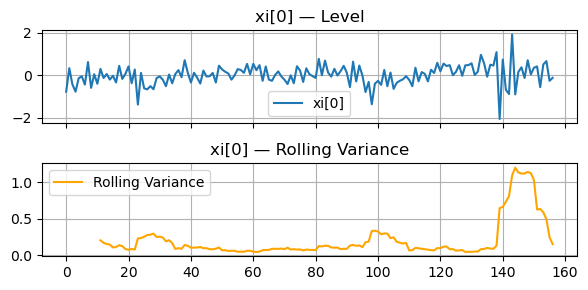

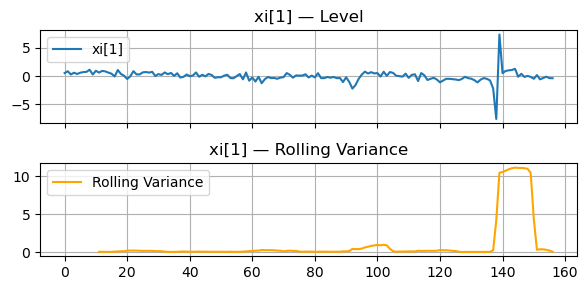

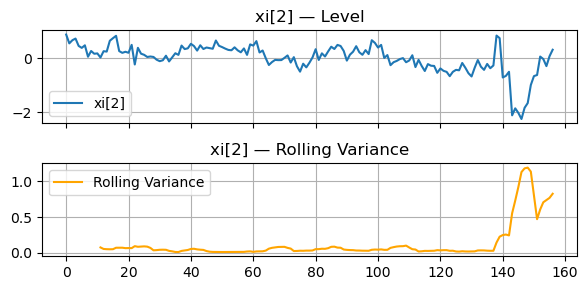

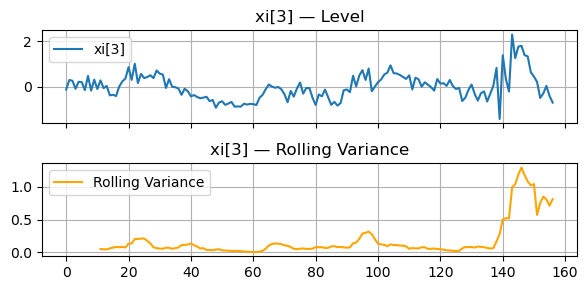

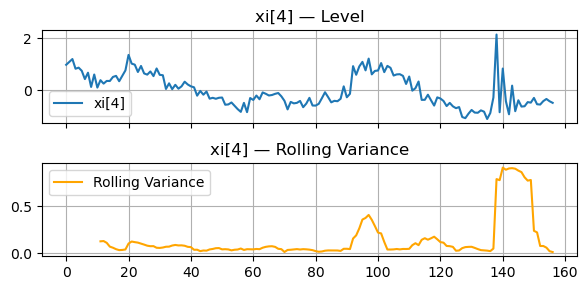

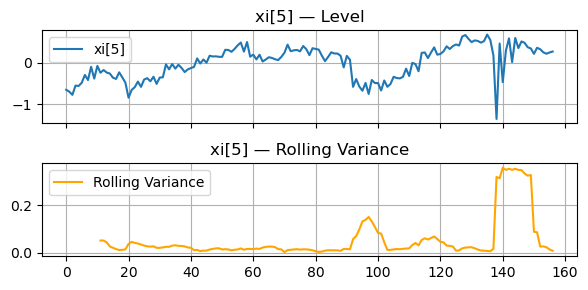

2025-05-07 15:52:36,132 - INFO - Stacked sanity checks completed.
2025-05-07 15:52:36,133 - INFO - Summary of checks:
{'white_xi': False, 'zero_mean_xi': False}


In [27]:
summary = run_kalman_initialization_checks(xi = xi,L = L)

#### Diagnostics

In the experiment run, we identify following issues:
- $\xi$ is autocorrelated.
- $\xi$ has non-zero mean.
- $\xi$ is heteroscedastic.
- The condition number of L is $10$ after ridge, which is acceptable.

### Kalman Filter

We implement the Kalman Filter for the linear Gaussian state-space model driven by whitened noise:

$$
X_t = A X_{t-1} + \bar{G} z_t,
$$
$$
Y_t = B X_t + \bar{H} z_t,
$$
where:
- $z_t \sim \mathcal{N}(0, I_{k+n})$ is standard white noise,
- $\bar{G} = [I_k, 0] L$,
- $\bar{H} = [0, I_n] L$.

---

#### Initialization

- **Initial state** \(X_0\):
  - Either set to zero,
  - Or initialized from PCA estimates.
- **Initial covariance** \(P_0\):
  $$
  P_0 = \text{certainty factor} \times I.
  $$

---

#### Kalman Filtering Procedure

At each time step $t = 0, \dots, T-1$:

- **Prediction Step**:
  $$
  \hat{X}_{t|t-1} = A X_{t-1},
  $$
  $$
  P_{t|t-1} = A P_{t-1} A^\top + \bar{G} \bar{G}^\top.
  $$

- **Update Step**:
  $$
  \hat{Y}_t = B \hat{X}_{t|t-1},
  $$
  $$
  \nu_t = Y_t - \hat{Y}_t,
  $$
  $$
  S_t = B P_{t|t-1} B^\top + \bar{H} \bar{H}^\top,
  $$
  $$
  K_t = P_{t|t-1} B^\top S_t^{-1},
  $$
  $$
  X_t = \hat{X}_{t|t-1} + K_t \nu_t,
  $$
  $$
  P_t = (I - K_t B) P_{t|t-1}.
  $$


In [23]:
kf = KalmanFilter(A=A, B=B, G=G_bar, H=H_bar)
kf.run_filter(Y=train_df_normalized.values)

We can see instant convergence of kalman gain. This is likely due to our observation covariance $\bar{H}\bar{H}^T$ being rank-deficient.

I believe the root cause is right now we do not have enough observable macro series. As we only look at four-dimensional observable, rank-deficiency plays a major part in calculation of kalman gain and prior covariance (making them stablizie rapidly).

#### Initial Parameter Evaluation

1. State estimate consistency
    - The filtered latent state trajectory $X_t$ is plotted against the PCA-initialized latent estimate. Confidence intervals are constructed from the diagonal of the posterior covariance matrix $P_t$, typically visualized as 95% bands. 

2. State magnitude and uncertainty over time
   - The norm $\|X_t\|$ is plotted to track the magnitude of the filtered state.
   - The trace of the posterior covariance matrix $\operatorname{tr}(P_t)$ is used to monitor how the uncertainty in state estimation evolves. 

3. Cross-covariance between state and innovation
   - Same as in initialization sanity check, the empirical cross-covariance between the filtered state $X_t$ and the innovation $\nu_t = Y_t - B X_t$ is computed. 

4. Innovation whiteness
   - Same as in initialization sanity check, each dimension of the innovation sequence $\nu_t$ is tested for autocorrelation. 

5. Innovation heteroscedasticity
   - Same as in initialization sanity check, the level and rolling variance of each innovation component are plotted over time to detect time-varying volatility. 

6. Innovation mean stability
   - Innovations should be approximately zero-mean under the Gaussian error assumption. 
   - Persistent nonzero means may indicate bias in the observation equation or incorrect model calibration.

7. One-step-ahead prediction accuracy
   - The Kalman filter’s forecast $\hat{Y}_{t+1|t} = B A X_t$ is compared with the actual observation $Y_{t+1}$. 
   - This out-of-sample evaluation reflects the filter’s predictive power and generalization performance.

8. Log-likelihood computation
   - The total log-likelihood is computed based on the innovations and their associated covariances:
   $$
   \log L(\theta \mid Y_{1:T}) = \sum_{t=1}^T \log \mathcal{N}(\nu_t \mid 0, S_t)
   $$
   where $S_t$ is the innovation covariance. 
   - The resulting score summarizes overall model fit and can be used for model selection or comparison.

#### One step ahead Prediction Evaluation:

2025-05-07 16:29:20,655 - INFO - === Kalman Pipeline Evaluation ===
2025-05-07 16:29:20,659 - INFO - Step 1: Evaluating state estimate consistency...
2025-05-07 16:29:20,662 - INFO - Plotting state consistency...


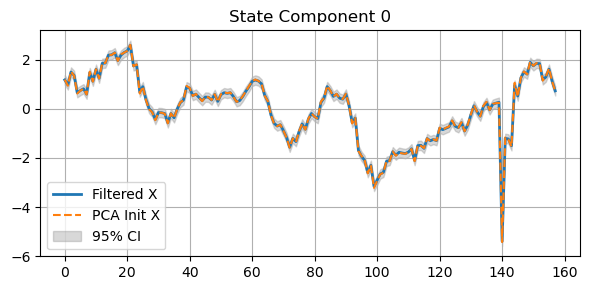

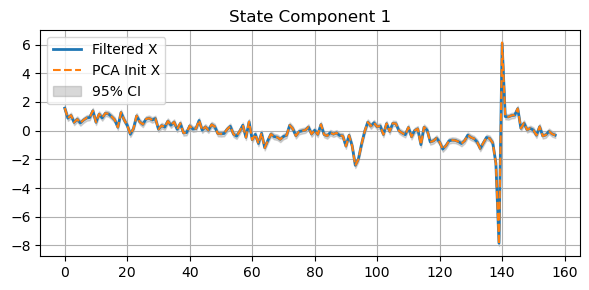

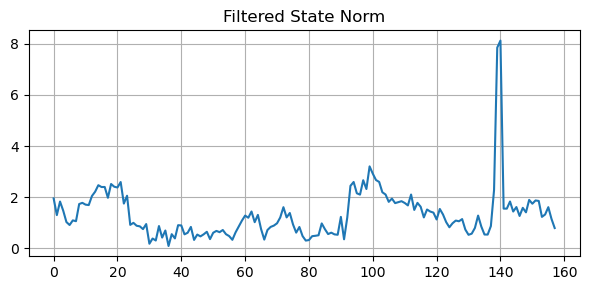

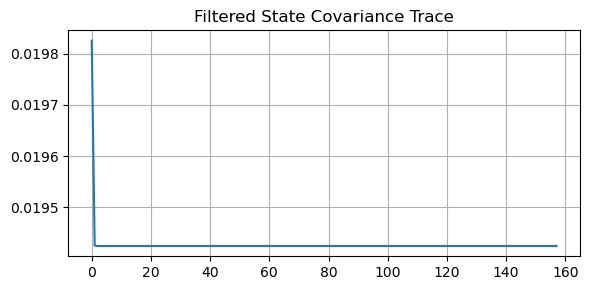

2025-05-07 16:29:21,815 - INFO - Step 2: Performing residual diagnostics...
2025-05-07 16:29:21,820 - INFO - Empirical Covariance between X_filt and Innovation:[[ 0.1034  0.1071 -0.1987 -0.1903]
 [ 0.1118  0.0523  0.5352  0.9387]]
2025-05-07 16:29:21,822 - WARNING - Max absolute cross-covariance (0.93869) exceeds tolerance (0.1) between X_filt and Innovation.
2025-05-07 16:29:21,829 - WARNING - Innovation[0] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:29:21,840 - WARNING - Innovation[1] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:29:21,849 - WARNING - Innovation[2] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:29:21,857 - INFO - Innovation[3] Ljung-Box p=0.8019 — no autocorrelation


Plotting residual diagnostics for Innovation:


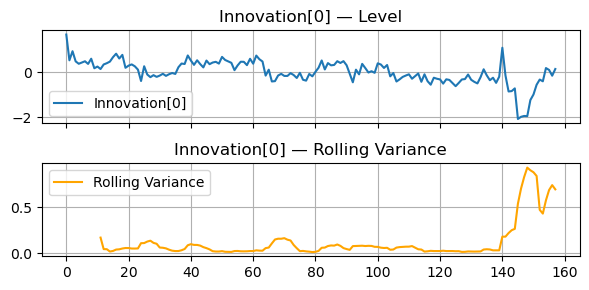

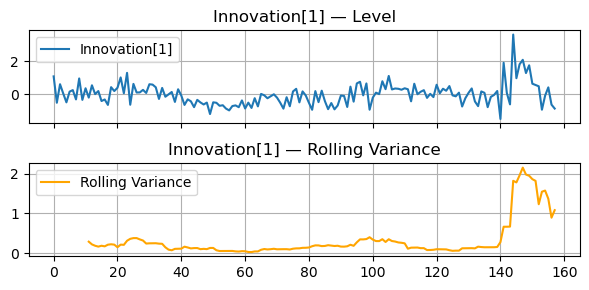

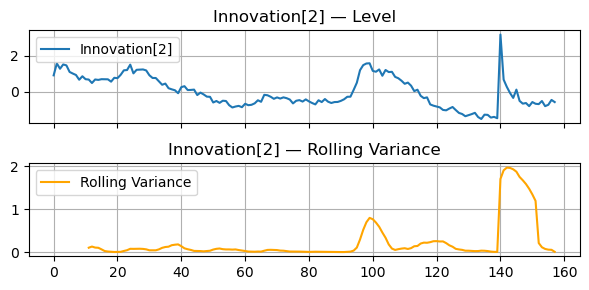

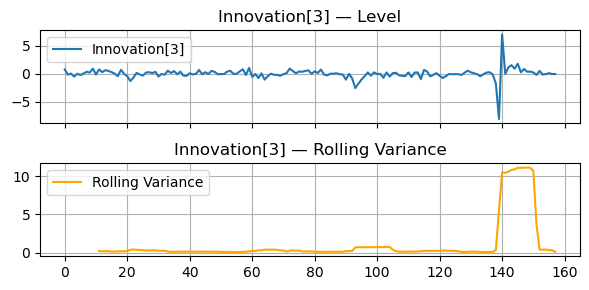

2025-05-07 16:29:24,175 - WARNING - Innovation mean not zero within tolerance 0.001: [ 0.0017  0.0017 -0.0014 -0.0001]
2025-05-07 16:29:24,176 - INFO - Step 3: Evaluating multi-step forecast (with decay)...
2025-05-07 16:29:24,177 - INFO - Evaluating Initial KF forecast up to t+1 with decay γ=0.7


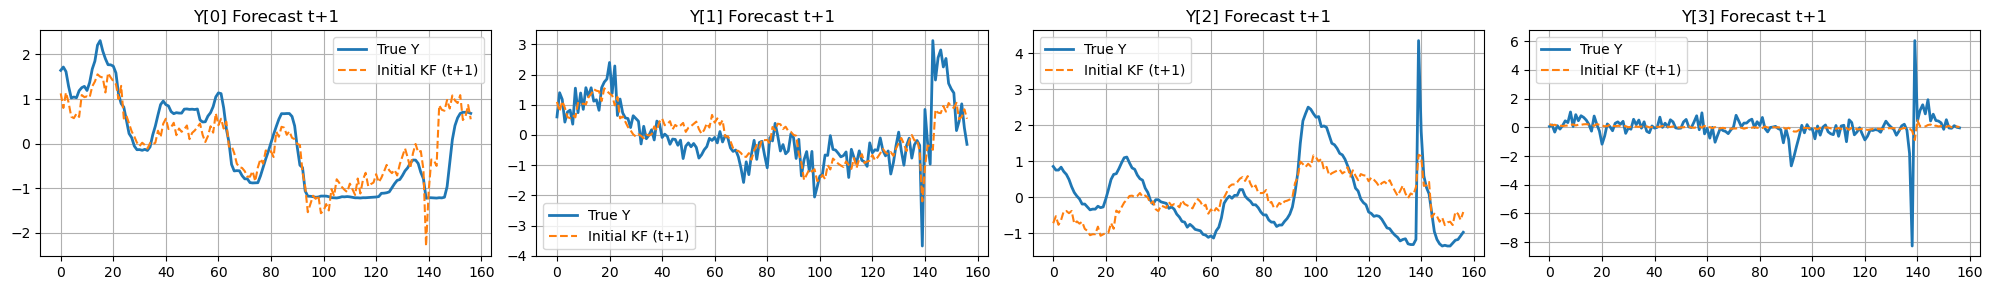

2025-05-07 16:29:25,326 - INFO - Total decay-weighted RMSE — Initial KF: 0.7579


In [24]:
initial_oneStep_rmse, initial_oneStep_metrics = evaluate_kalman_pipeline(Y=train_df_normalized.values, X_filt=kf.X_filt, X_pca=train_latent_df, B=B, A=A, innovations=kf.innovations,
                         P_all=kf.P_all, max_horizon=1, label='Initial KF')

#### Up to four step ahead Prediction Evaluation

2025-05-07 16:29:27,302 - INFO - === Kalman Pipeline Evaluation ===
2025-05-07 16:29:27,304 - INFO - Step 1: Evaluating state estimate consistency...
2025-05-07 16:29:27,306 - INFO - Plotting state consistency...


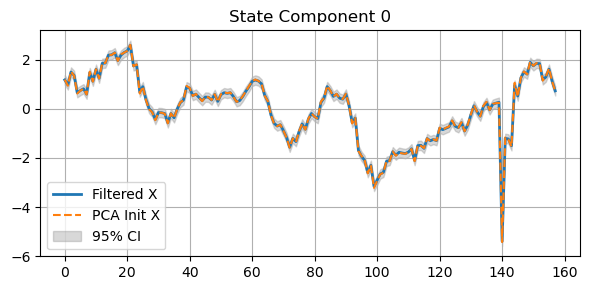

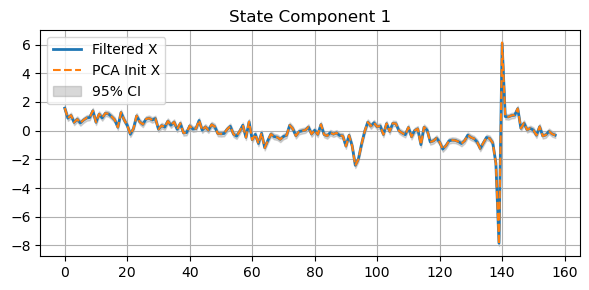

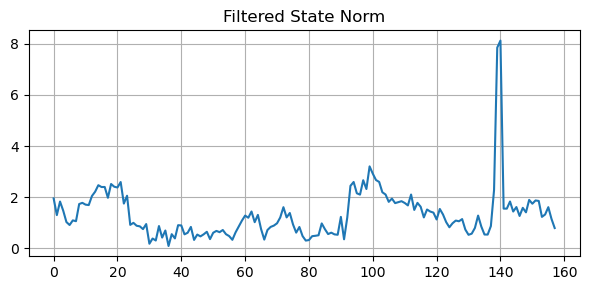

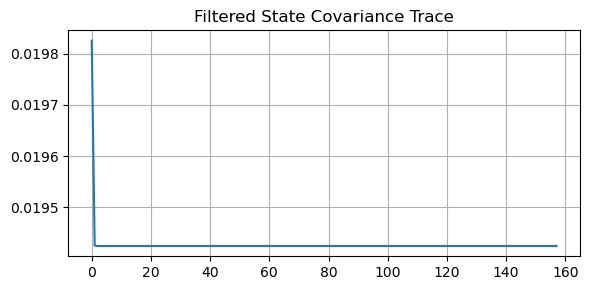

2025-05-07 16:29:28,336 - INFO - Step 2: Performing residual diagnostics...
2025-05-07 16:29:28,339 - INFO - Empirical Covariance between X_filt and Innovation:[[ 0.1034  0.1071 -0.1987 -0.1903]
 [ 0.1118  0.0523  0.5352  0.9387]]
2025-05-07 16:29:28,341 - WARNING - Max absolute cross-covariance (0.93869) exceeds tolerance (0.1) between X_filt and Innovation.
2025-05-07 16:29:28,344 - WARNING - Innovation[0] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:29:28,347 - WARNING - Innovation[1] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:29:28,351 - WARNING - Innovation[2] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:29:28,359 - INFO - Innovation[3] Ljung-Box p=0.8019 — no autocorrelation


Plotting residual diagnostics for Innovation:


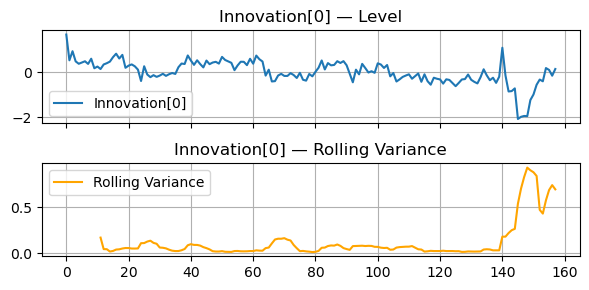

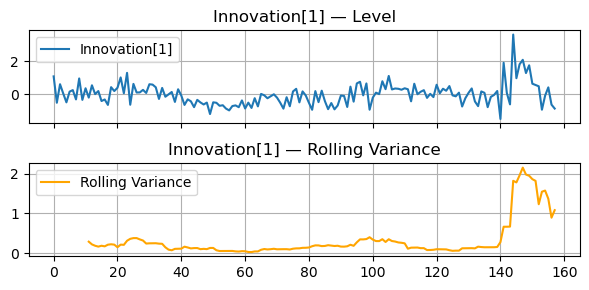

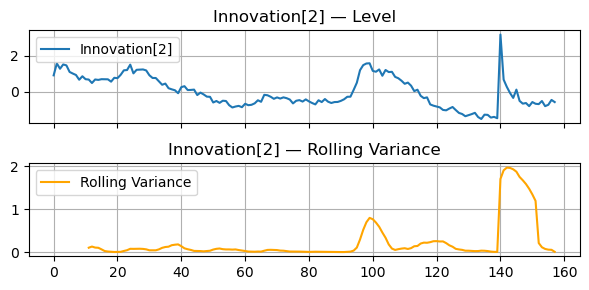

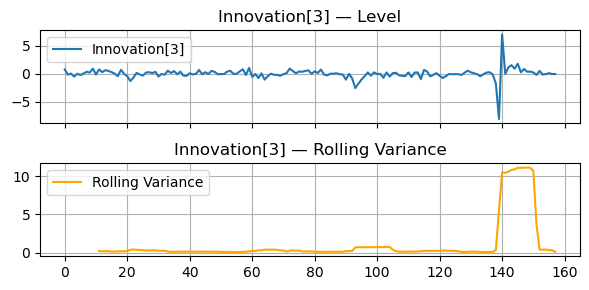

2025-05-07 16:29:29,743 - WARNING - Innovation mean not zero within tolerance 0.001: [ 0.0017  0.0017 -0.0014 -0.0001]
2025-05-07 16:29:29,744 - INFO - Step 3: Evaluating multi-step forecast (with decay)...
2025-05-07 16:29:29,744 - INFO - Evaluating Initial KF forecast up to t+4 with decay γ=0.7


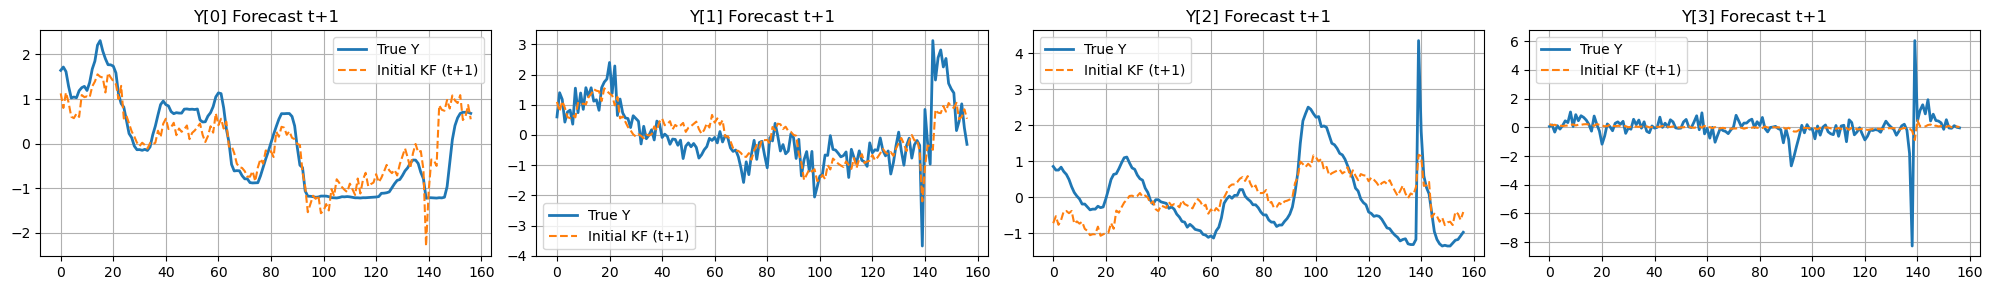

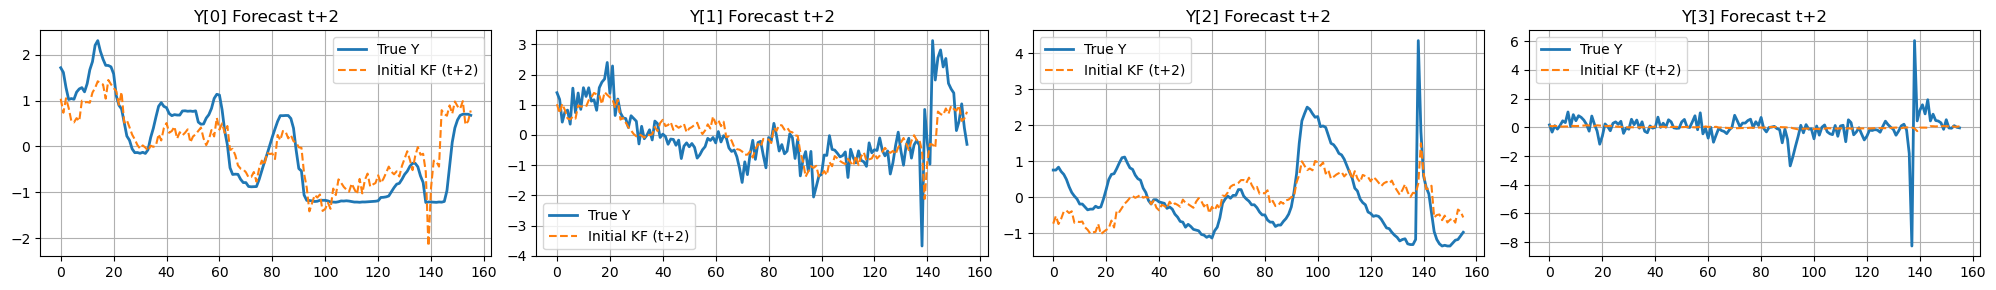

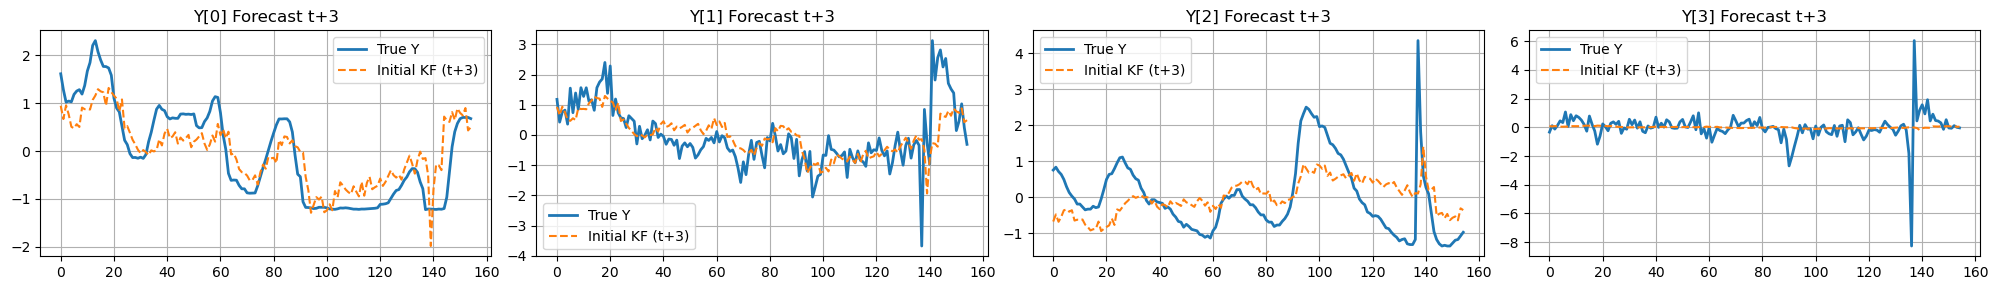

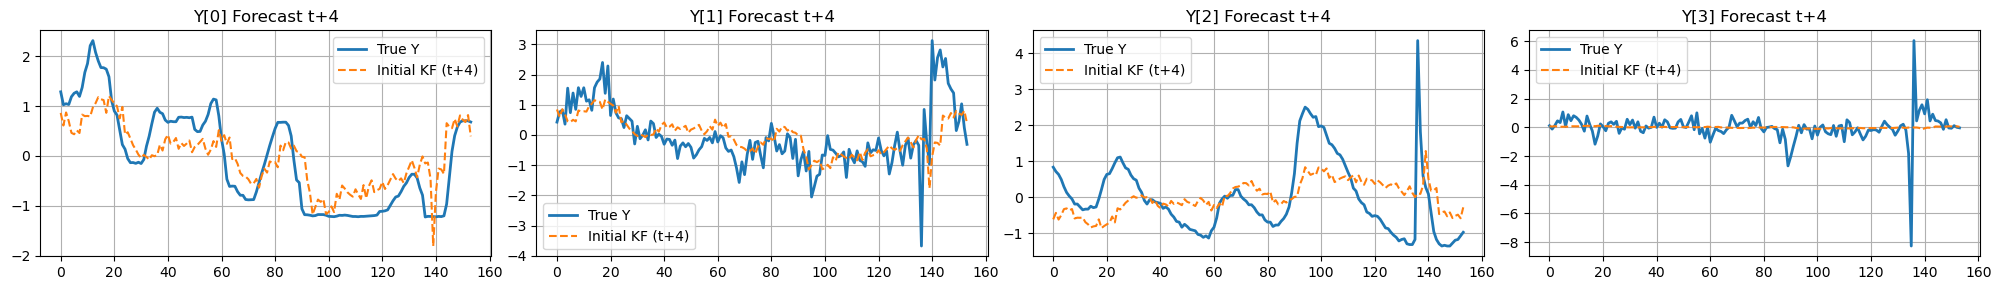

2025-05-07 16:29:33,454 - INFO - Total decay-weighted RMSE — Initial KF: 1.9912


In [25]:
initial_fourStep_rmse, initial_fourStep_metrics = evaluate_kalman_pipeline(Y=train_df_normalized.values, X_filt=kf.X_filt, X_pca=train_latent_df, B=B, A=A, innovations=kf.innovations,
                         P_all=kf.P_all, max_horizon=4, label='Initial KF')

#### Evaluation

In the experiment run, we identify following issues:
- Filtered state $X_t$ and innovation $\eta_t$ are not orthogonal, with empirical cross-covariance:
  $$
  \max |\operatorname{Cov}(X_t, \eta_t)| = 0.94
  $$
  - Likely due to omitted latent structure or incorrect observation model $H$.
- Innovations $\eta_t$ are not white noise:
    - Transition matrix $A$ may not fully capture temporal dynamics; consider a higher-order VAR process
- Innovations $\eta_t$ are heteroscedastic.
    - confirm the necessity of rolling window setup?

## Optimization

- The optimization minimizes MSE over prediction horizons:

$$
\mathcal{L} = \sum_{n=1}^{N} \gamma^{n-1} \cdot \mathbb{E}\left[ \left\| Y_{t+n} - \hat{Y}_{t+n} \right\|^2 \right]
$$

where:

- $\hat{Y}_{t+n} = B A^n X_t$
- $\mathbb{E}[\,\cdot\,]$ is the empirical mean over samples
- $\gamma = 0.7$ is decay factor

Regularization can be applied, which is discussed in details below.

- In evaluation, I use

$$
\text{RMSE}= \sum_{n=1}^{N} \gamma^{n-1} \cdot \frac{1}{d} \sum_{i=1}^{d} \sqrt{ \mathbb{E} \left[ \left( Y_{t+n}^{(i)} - \hat{Y}_{t+n}^{(i)} \right)^2 \right] }
$$

where:

- $d$ is the number of observed variables


### Disclaimer on Optimization Experiments

I didn’t apply a train/test split during optimizer tuning — mostly because I forgot at the start and only realized midway through. 

Later, I went back and tried splitting the data differently, but the results varied a lot depending on the window. I don’t have time right now to fully explore why generalization is unstable, so all results here are in-sample only. But I'm happy to show the difference onsite.

This section is meant to be exploratory. It shows how the model behaves under different training setups, but doesn’t say anything about how it would perform on unseen data.

#### One Step ahead Prediction Evaluation:

##### Initial Blocker:

Originally I observe a simultaneous spike in loss and gradient norms in early stage of training. 

<p align="center">
  <img src="plots/diagnostics/loss_spike.png" alt="Plot" width="600"/>
</p>

The loss recovers and gradient settles, suggesting the spike is likely due to a local overshoot.

##### Current Status:

To allevate the situation, I lowered my initial learning rate and applied exponential decaying schedule, which gives me something better, a smooth loss convergence.

Gradient show a initial spike around step 50, but to a controllable magnitude. This may stem from initial instability of Kalman filter or sharpe loss surface at initialization.

Desipte the loss curve being smooth and converging, we can observe frequent gradient spikes both around late stage of training. This might suggest our model is within a locally flat region in late stage, in which case gradients fluctuate without changing the loss much. This is most prominet in $||H||$, possibly because the model pushes observation noise around to reduce loss. In this case, I think gradient spike is not a problem w.r.t our training data. 

In [17]:
def make_lr_schedule(init_value, decay_rate, N):
    transition_steps = max(1, int(0.2 * N))
    lr_schedule = optax.exponential_decay(
        init_value=init_value,
        transition_steps=transition_steps,
        decay_rate=decay_rate,
        staircase=True
    )
    return lr_schedule


def train_and_evaluate_kalman(
    Y,
    X_pca,
    A,
    B,
    G_bar,
    H_bar,
    config,
    max_horizon,
    label,
    num_steps: int = 300,
    optimizer = None,
    lr_schedule = None,
    config_callback=None,
    post_eval: bool = False
):
    """
    Run full Kalman training and evaluation pipeline with optional optimizer and learning rate schedule.
    Main diagnostics are plotted by default; other plots are optional.
    """

    params_init = {"A": A, "B": B, "G": G_bar, "H": H_bar}

    if optimizer is None:
        init_value, decay_rate, size = (5e-3, 0.95, Y.shape[0])
        lr_schedule = make_lr_schedule(init_value,decay_rate, size)
        optimizer = optax.adam(learning_rate=lr_schedule)

    trainer = KalmanTrainer(
        Y=Y,
        params_init=params_init,
        optimizer=optimizer,
        config=config,
        config_callback=config_callback # config_callback will replace config when it is not None (i.e. penalty weight scheduling & curriculum training)
    )

    trained_params = trainer.train(num_steps=num_steps)
    trainer.main_diagnostics()
    
    if post_eval:

        post_kf = KalmanFilter(
            A=trained_params["A"],
            B=trained_params["B"],
            G=trained_params["G"],
            H=trained_params["H"],
            config=config
        )
        post_kf.run_filter(Y)

        rmse, metrics = evaluate_kalman_pipeline(
            Y=Y,
            X_filt=post_kf.X_filt,
            X_pca=X_pca,
            B=trained_params["B"],
            A=trained_params["A"], 
            innovations=post_kf.innovations,
            P_all=post_kf.P_all,
            max_horizon = max_horizon, # still need to specifiy max_horizon for post_evaluation,
            label = label,
            baseline_X = X_pca.values,
            baseline_A = A,
            baseline_B = B
        )

        return rmse, metrics
    return


2025-05-07 16:09:43,327 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:09:43,791 - INFO - [Step 030] Loss: 0.565992
2025-05-07 16:09:44,265 - INFO - [Step 060] Loss: 0.461688
2025-05-07 16:09:44,906 - INFO - [Step 090] Loss: 0.435245
2025-05-07 16:09:45,443 - INFO - [Step 120] Loss: 0.427729
2025-05-07 16:09:45,874 - INFO - [Step 150] Loss: 0.424769
2025-05-07 16:09:46,299 - INFO - [Step 180] Loss: 0.423622
2025-05-07 16:09:46,731 - INFO - [Step 210] Loss: 0.422920
2025-05-07 16:09:47,156 - INFO - [Step 240] Loss: 0.422695
2025-05-07 16:09:47,581 - INFO - [Step 270] Loss: 0.422506
2025-05-07 16:09:47,990 - INFO - [Final Step 299] Loss: 0.422445


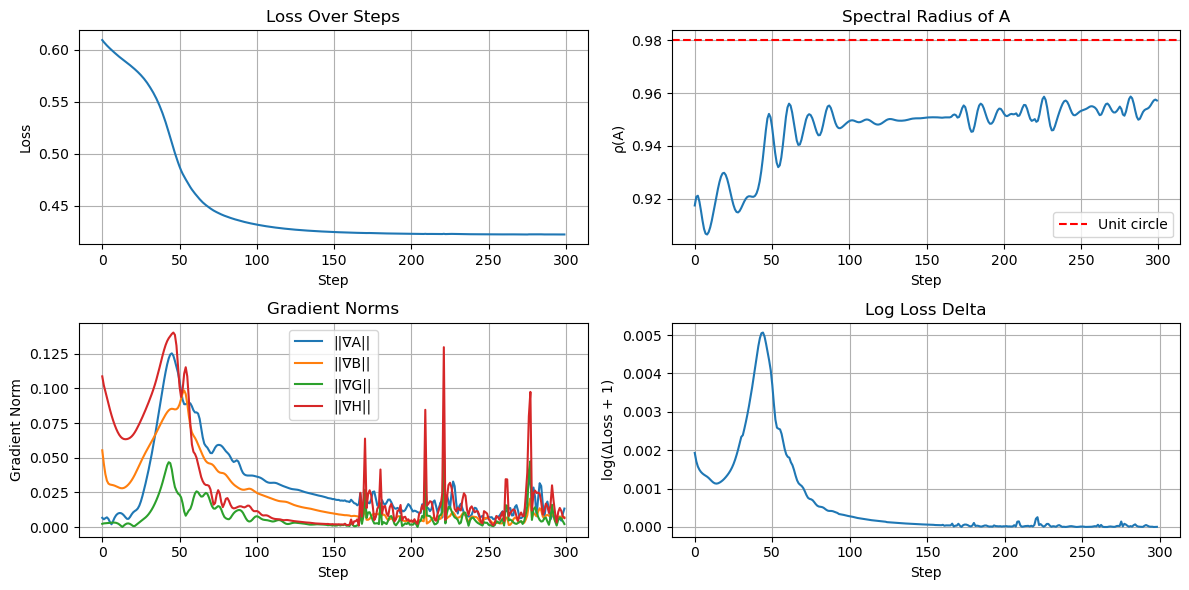

In [46]:
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = None,
    max_horizon = 1,
    label = 'Optimized One Step KF'
)

### Topic One -  Regularization:

To stabilize our Kalman filter, I applied L2 regularization over $A$ and $G$ in the loss func, with penalty parameter $\lambda_A = 1e-2$, $\lambda_G = 1e-3$.

- The total gradient with L2 regularization is:

    $$
    \nabla_W \mathcal{L}_{\text{total}} = \nabla_W \mathcal{L}+ 2\lambda W
    $$

    The corresponding parameter update is, roughly using the example of SGD:

    $$
    W \leftarrow W - \eta \left( \nabla_W \mathcal{L} + 2\lambda W \right)
    $$.

    Thus, in late stage L2 regularization helps shrink $||W||$ and stablizes gradient even when $\nabla_W \mathcal{L}$ is volatile. 

- It is appearant that large values of A directly leads to explosive states and instable Kalman filter. Hard projection on A, however, can lead to nonsmooth jump in curve, thus L2 is a better alternative. As for G, If it's too large, the latent state becomes noisy → harder to predict. 

- The result shows a bias and variance tradeoff:

    Gradient norms become much smoother post regularization, but the rmse slightly increases from 0.585 to 0.586. We need in-sample / oos split to test whether regularization improves forecasting on unseen data.

##### Warning:
We should nevertheless be cautious of over-constraining the latent dynamics (through penalizing A and G) which force the model to transit flexibility to observation noise $H$. Moreover, penalizing over $||H||$ affects innovation covariance singularity and its impact is more uncontrollable as I would show later.

2025-05-07 16:10:24,880 - INFO - [Step 000] Loss: 0.620204
2025-05-07 16:10:25,408 - INFO - [Step 030] Loss: 0.579603
2025-05-07 16:10:25,832 - INFO - [Step 060] Loss: 0.484585
2025-05-07 16:10:26,252 - INFO - [Step 090] Loss: 0.451568
2025-05-07 16:10:26,692 - INFO - [Step 120] Loss: 0.444348
2025-05-07 16:10:27,152 - INFO - [Step 150] Loss: 0.441869
2025-05-07 16:10:27,642 - INFO - [Step 180] Loss: 0.440890
2025-05-07 16:10:28,207 - INFO - [Step 210] Loss: 0.440462
2025-05-07 16:10:28,732 - INFO - [Step 240] Loss: 0.440246
2025-05-07 16:10:29,192 - INFO - [Step 270] Loss: 0.440115
2025-05-07 16:10:29,622 - INFO - [Final Step 299] Loss: 0.440025


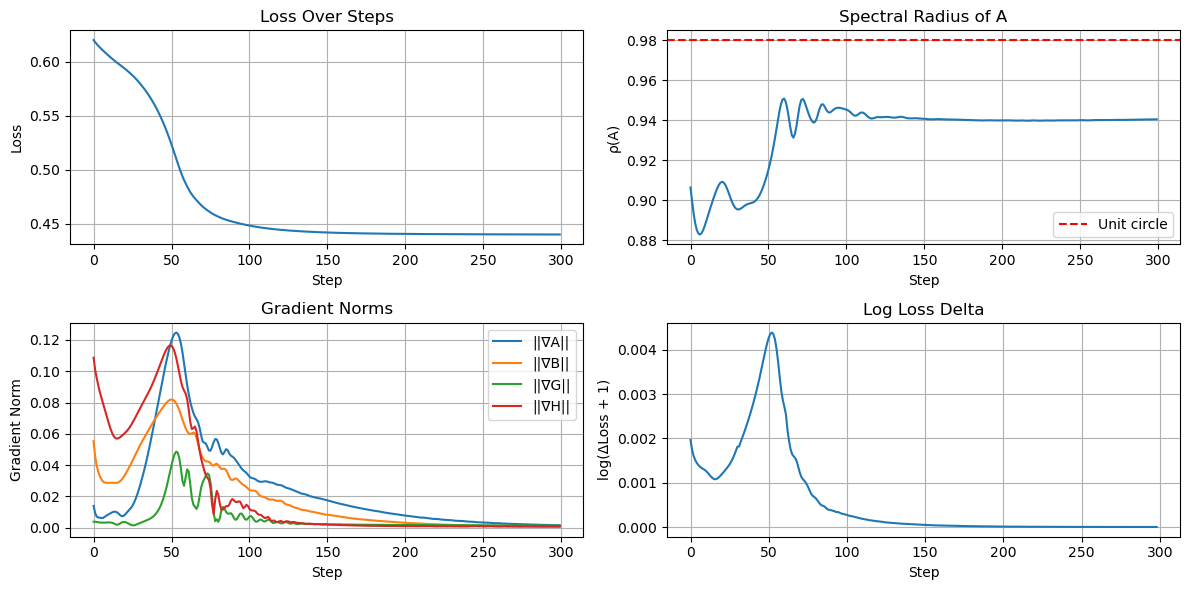

In [47]:
regularize_config = KalmanFilterConfig(lambda_A=1e-2, lambda_G=1e-3, lambda_H=0)
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = regularize_config,
    max_horizon=1,
    label = 'Optimized One Step KF'
)

##### Penalty over $H$

Applying penalty over $\|H\| $ is not recommended through my experiment, for the following reason:

In the model,
$$
x_t = A x_{t-1} + G \xi_t, \quad y_t = B x_t + H \xi_t,
$$
$ H $ controls the direct influence of the shared disturbance $ \xi_t $ on the observations. Penalizing $ H $ via an L2 term pulls $ H \to 0 $.

This can cause the innovation covariance,
$$
S_t = B P B^\top + H H^\top + \text{cross-terms},
$$
to become nearly singular. As a result,$ S_t^{-1} $ may become numerically unstable or large, leading to erratic and oversized Kalman gain $ K_t $.

Consequently:
- Even small changes in $ H $ lead to large changes in the filtered states.
- The loss becomes highly sensitive to $ H $, causing exploding gradients $ \nabla_H \mathcal{L} $.
- The optimization surface becomes non-smooth and harder to traverse.

In practice, by setting $ \lambda_H = 10^{-3} $ , gradient norms for $ H $ jitter during late training stages, reflecting the instability introduced by regularizing this term.


2025-05-07 16:13:17,469 - INFO - [Step 000] Loss: 0.621400
2025-05-07 16:13:17,930 - INFO - [Step 030] Loss: 0.581199
2025-05-07 16:13:18,438 - INFO - [Step 060] Loss: 0.486393
2025-05-07 16:13:18,950 - INFO - [Step 090] Loss: 0.453322
2025-05-07 16:13:19,414 - INFO - [Step 120] Loss: 0.446021
2025-05-07 16:13:19,931 - INFO - [Step 150] Loss: 0.443482
2025-05-07 16:13:20,345 - INFO - [Step 180] Loss: 0.442411
2025-05-07 16:13:20,801 - INFO - [Step 210] Loss: 0.441879
2025-05-07 16:13:21,438 - INFO - [Step 240] Loss: 0.441568
2025-05-07 16:13:22,028 - INFO - [Step 270] Loss: 0.441328
2025-05-07 16:13:22,467 - INFO - [Final Step 299] Loss: 0.441155


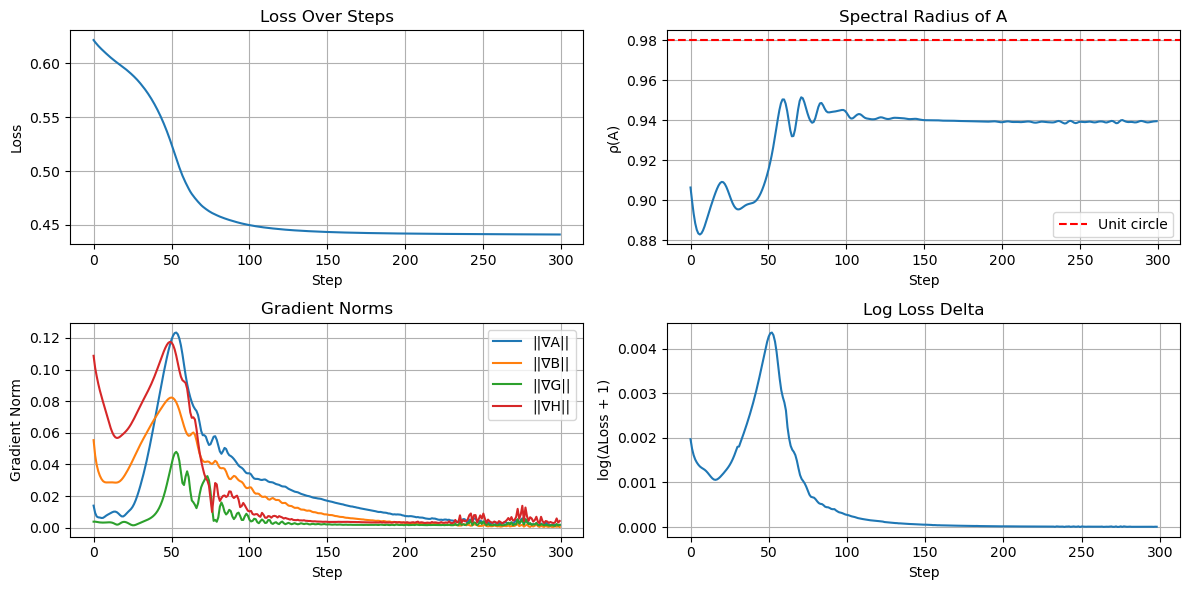

In [15]:
regularize_config = KalmanFilterConfig(lambda_A=1e-2, lambda_G=1e-3, lambda_H=1e-3)
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = regularize_config,
    max_horizon=1,
    label = 'Optimized One Step KF'
)

##### Penalty over $ G $

Similarly, it's natural to think what happens if $ G $ is over-penalized:

- The predicted state covariance becomes low-rank or even degenerate:
  $$
  P_{t|t-1} = A P_{t-1|t-1} A^\top + G G^\top \to A P A^\top,
  $$
  which lacks uncertainty propagation and leads to overconfident predictions.
- Since $G$ also enters into innovation covariance $ S_t $ through cross terms, there is again a risk of near-singularity for $S_t$. In which case, the Kalman gain becomes overreacting to noise in the observations.
- Moreover, from an optimization perspective, a nearly deterministic latent trajectory creates a fragile gradient landscape. Backpropagation becomes sensitive to small deviations in other parameters, especially $H$. As I have mentioned before, this leads to increased gradient variance or oscillations in unrelated parameters (i.e. $H$) as the model struggles to compensate for under-modeled process noise.

Empirically, we observed that with $ \lambda_G = 10^{-2} $, gradient norms for $ H $ and even $ B $ began to spike, suggesting the model was attempting to explain all residual variance through the observation side.

Therefore, regularization over $ G $ must be applied with caution, ensuring sufficient stochastic.

2025-05-07 16:13:27,218 - INFO - [Step 000] Loss: 0.632069
2025-05-07 16:13:27,815 - INFO - [Step 030] Loss: 0.587157
2025-05-07 16:13:28,356 - INFO - [Step 060] Loss: 0.493676
2025-05-07 16:13:28,785 - INFO - [Step 090] Loss: 0.455510
2025-05-07 16:13:29,272 - INFO - [Step 120] Loss: 0.447011
2025-05-07 16:13:29,811 - INFO - [Step 150] Loss: 0.443808
2025-05-07 16:13:30,267 - INFO - [Step 180] Loss: 0.442274
2025-05-07 16:13:30,753 - INFO - [Step 210] Loss: 0.441443
2025-05-07 16:13:31,333 - INFO - [Step 240] Loss: 0.440993
2025-05-07 16:13:31,875 - INFO - [Step 270] Loss: 0.440819
2025-05-07 16:13:32,365 - INFO - [Final Step 299] Loss: 0.440652


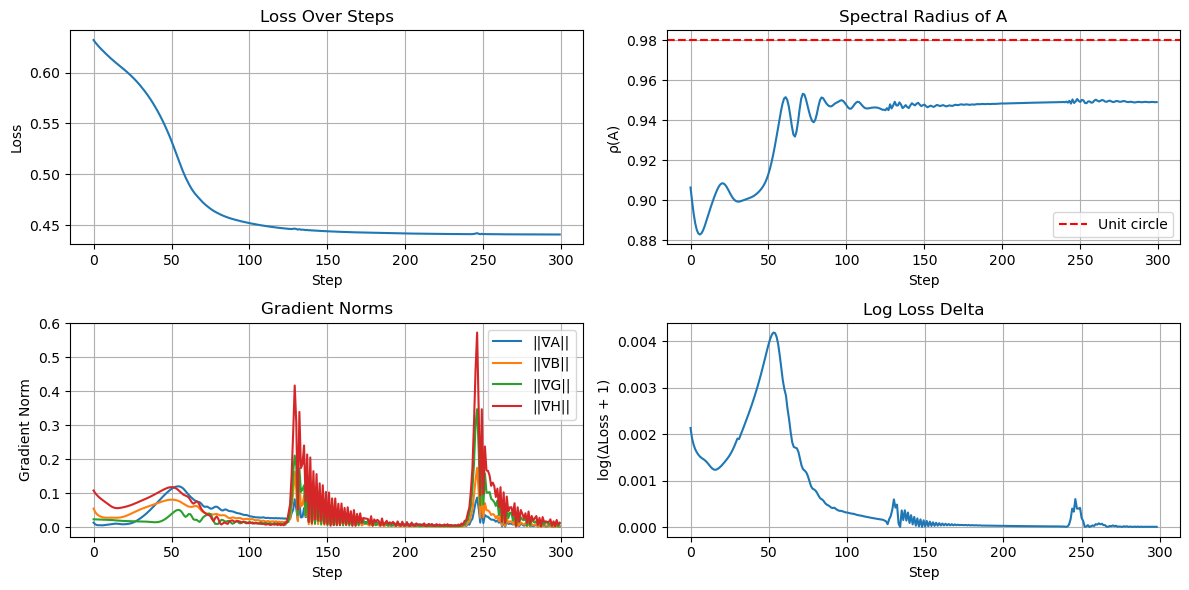

In [16]:
regularize_config = KalmanFilterConfig(lambda_A=1e-2, lambda_G=1e-2, lambda_H=0)
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = regularize_config,
    max_horizon=1,
    label = 'Optimized One Step KF'
)

While L2 regularization is a powerful tool for stabilizing training, the penalty weight must be handled with care. 

These issues become even more prominent under multi-step prediction loss, where parameter-induced errors accumulate recursively.

#### Up to four step ahead Prediction Evaluation

First we see the result without regularization:

- The loss curve is clean and smoothly decreasing.

- Gradient norm experiences early spike then decays to zero as experienced in one-step case.

**Improvement Setting**

As I’ll show later, regularization adds little benefit in the multi-step prediction setting, whereas curriculum learning — which eases the model in by starting with simpler tasks — can bring convergent MSE down to 2.00.

2025-05-07 16:13:57,255 - INFO - [Step 000] Loss: 0.248441
2025-05-07 16:13:57,790 - INFO - [Step 030] Loss: 0.238780
2025-05-07 16:13:58,254 - INFO - [Step 060] Loss: 0.238029
2025-05-07 16:13:58,735 - INFO - [Step 090] Loss: 0.237854
2025-05-07 16:13:59,166 - INFO - [Step 120] Loss: 0.237745
2025-05-07 16:13:59,586 - INFO - [Step 150] Loss: 0.237657
2025-05-07 16:14:00,025 - INFO - [Step 180] Loss: 0.237575
2025-05-07 16:14:00,532 - INFO - [Step 210] Loss: 0.237489
2025-05-07 16:14:01,092 - INFO - [Step 240] Loss: 0.237386
2025-05-07 16:14:01,594 - INFO - [Step 270] Loss: 0.237251
2025-05-07 16:14:02,026 - INFO - [Final Step 299] Loss: 0.237040


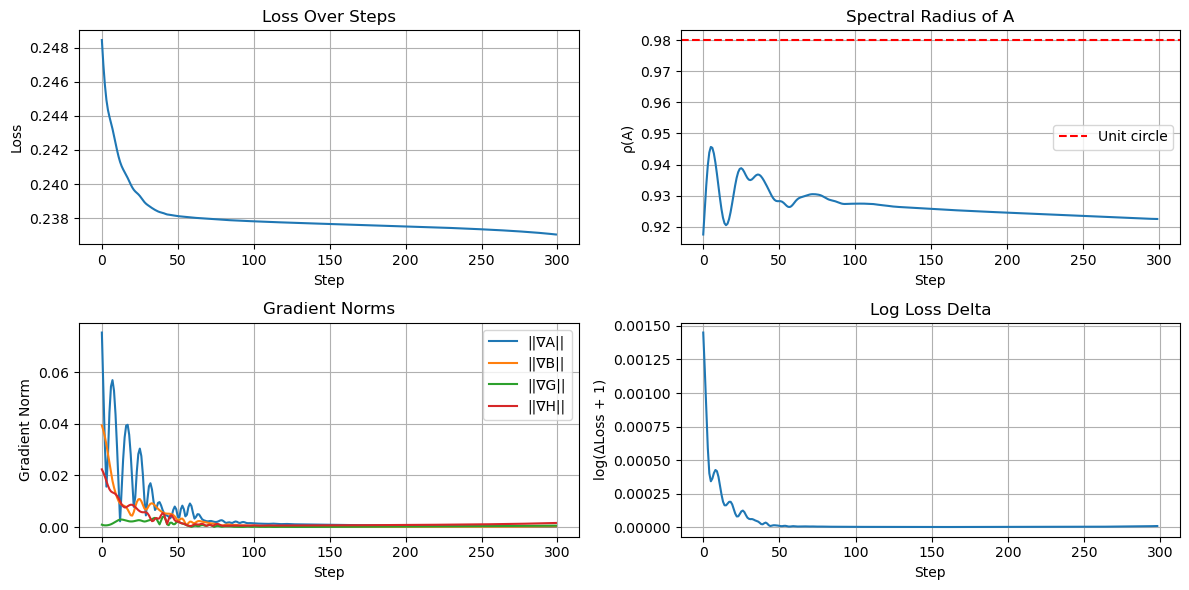

In [17]:
multi_period_config = KalmanFilterConfig(max_horizon=4)
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = multi_period_config,
    max_horizon=4,
    label = 'Optimized Four Step KF'
)

##### Regularization in Multi-step:

Over-constraining latent dynamics becomes a more problematic issue for multi-step forecasts. IAs the forecast horizon extends, the model requires greater flexibility in the latent transition and noise structure to account for uncertainty propagation and compounding errors.

Empirically, we observe that applying the same regularization strength used in the one-step case (e.g., $ \lambda_A = 10^{-2}, \lambda_G = 10^{-3} $) leads to instability in the multi-step setup. Specifically, we see spiking gradient norms in $ G $ and $ H $, as well as jittery loss behavior in later training stages — indicating the optimizer struggles to reconcile tight constraints with the broader temporal dynamics.

2025-05-07 16:14:19,990 - INFO - [Step 000] Loss: 0.259452
2025-05-07 16:14:20,499 - INFO - [Step 030] Loss: 0.249657
2025-05-07 16:14:20,997 - INFO - [Step 060] Loss: 0.247287
2025-05-07 16:14:21,699 - INFO - [Step 090] Loss: 0.246547
2025-05-07 16:14:22,313 - INFO - [Step 120] Loss: 0.246259
2025-05-07 16:14:22,783 - INFO - [Step 150] Loss: 0.246106
2025-05-07 16:14:23,220 - INFO - [Step 180] Loss: 0.245967
2025-05-07 16:14:23,648 - INFO - [Step 210] Loss: 0.245777
2025-05-07 16:14:24,089 - INFO - [Step 240] Loss: 0.244989
2025-05-07 16:14:24,596 - INFO - [Step 270] Loss: 0.244618
2025-05-07 16:14:25,042 - INFO - [Final Step 299] Loss: 0.244368


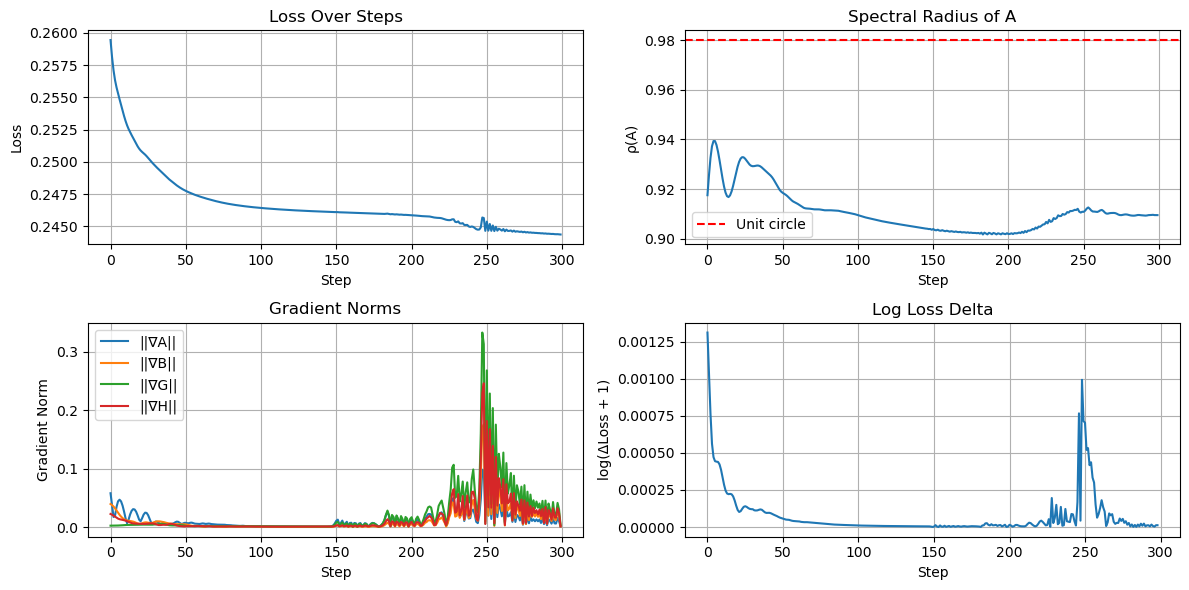

In [18]:
multi_period_regularize_config = KalmanFilterConfig(lambda_A=1e-2, lambda_G=1e-3, lambda_H=0, max_horizon=4)
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = multi_period_regularize_config,
    max_horizon=4,
    label = 'Optimized Four Step KF'
)

##### Adaptive Regularization Strategy

As a workaround, I adopt an adaptive schedule for  L2 regularization as well. The key idea is to apply stronger constraints on the latent dynamics at the beginning and to relax them gradually as learning progresses.

I apply exponential decay to the regularization strengths for $ A $ and $ G $ as follows:

$$
\lambda^{(t)} = \max\left( \lambda_0 \cdot \text{decay\_rate}^t, \ \lambda_{\text{min}} \right)
$$

The initial penalty configuration is same as before.

2025-05-07 16:14:49,961 - INFO - [Step 000] Loss: 0.259452
2025-05-07 16:15:04,972 - INFO - [Step 030] Loss: 0.238850
2025-05-07 16:15:05,403 - INFO - [Step 060] Loss: 0.238014
2025-05-07 16:15:05,838 - INFO - [Step 090] Loss: 0.237840
2025-05-07 16:15:06,260 - INFO - [Step 120] Loss: 0.237738
2025-05-07 16:15:06,687 - INFO - [Step 150] Loss: 0.237657
2025-05-07 16:15:07,138 - INFO - [Step 180] Loss: 0.237582
2025-05-07 16:15:07,650 - INFO - [Step 210] Loss: 0.237502
2025-05-07 16:15:08,382 - INFO - [Step 240] Loss: 0.237405
2025-05-07 16:15:08,942 - INFO - [Step 270] Loss: 0.237273
2025-05-07 16:15:09,368 - INFO - [Final Step 299] Loss: 0.237063


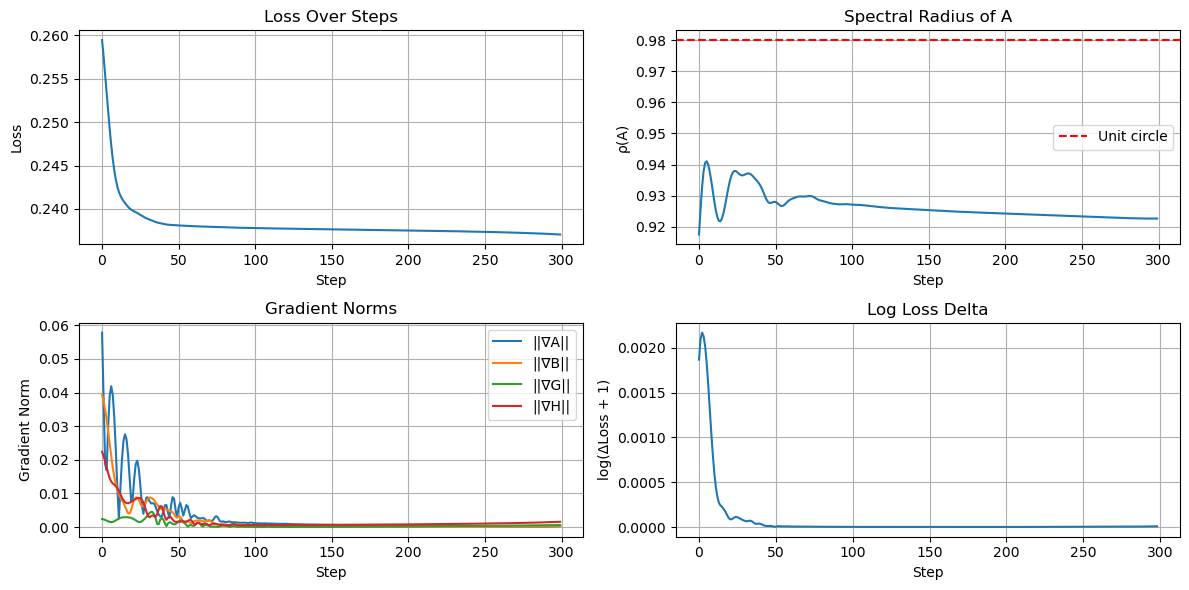

In [19]:
def adaptive_regularization_callback(step, config, decay_rate=0.95, min_lambda=1e-5):
    def decay(base_lambda): return max(base_lambda * (decay_rate ** step), min_lambda)

    return KalmanFilterConfig(
        **{**config.__dict__,
           "lambda_A": decay(config.lambda_A),
           "lambda_G": decay(config.lambda_G)}
    )
regularize_config = KalmanFilterConfig(lambda_A=1e-2, lambda_G=1e-3, lambda_H=0, max_horizon=4)

train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = regularize_config,
    max_horizon=4,
    config_callback = lambda step, cfg: adaptive_regularization_callback(step, cfg),
    label = 'Optimized Four Step KF'
)


##### Final Takeaway on Regularization (Not Recommended in Current Naive Setting):

Since latent and observation dynamics are closely intertwined, over- and under-regularizing one parameter can affect the behavior of other parameters in non-linear way. This often results in gradient instability or unintended compensatory updates across components.

In practice, it is often more effective to first stabilize training through smaller learning rates. If instability persists, applying decaying regularization weights offers a gentler constraint than static L2 penalties.

Thus, while regularization can help stabilize training, excessive or fixed penalties may distort the optimization trajectory and reduce model flexibility—especially in multi-step forecasting tasks.

### Topic Two -  Optimizer:

##### Learning Rate Exploration

Since I have touched on learning rate in the previous section, let's briefly go through its impact using a simple experiment below:

We compare three learning rate schedules using Adam with exponential decay:

The configurations tested are:

- (1e-3, 0.95): conservative learning
- (5e-3, 0.95): moderate learning
- (1e-2, 0.90): aggressive learning with faster decay


**Case 1 - Conservative Learning**

This schedule exhibits a slow and steady decline in training loss, but with a notable spike in gradient norms around mid stage, especially for $B$ and $H$. It is worth noting that the gradients of $A$ and $G$ remain nearly zero in early phase.

This suggests that the low learning rate causes the optimizer to initially under-updates latent space, then shifts pressure to observation dynamics, triggering instability later.


**Case 2 — Balanced Learning**

This is the setting we used in prior training. It leads to faster and smoother convergence. Gradient norms oscillate in late stage, but as analyzed before, the model likely reaches a flat region.

This setting avoids early stagnation while preventing late-stage instability. 


**Case 3 — Aggressive Learning**

Here, the optimizer converges very quickly in early stages, but suffers from sharp oscillations in middle phase. A large spike in the gradient norm of \( H \) is observed, indicating instability in the measurement noise mapping. The spectral radius of $A$ also fluctuates and rise to boundary, suggesting the model attempts to strech latent states to fix errors.

This configuration likely overshoots early and force correction via erratic update on observation noise $H$. 

**Final Takeaway**

Conservative learning may cause underfitting in certain parameters , forcing other parameters to overcompensate. Aggressive learning may cause overshooting and instability.

**Regarding learning rate scheduling**

While Adam adapts learning rate to handle direction and scale, it is still helpful to tell it when to slow down with scheduling.




=== Optimizer Performance ===
Initial Learning Rate: 0.001, Decay Rate: 0.95


2025-05-07 16:18:02,944 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:18:03,464 - INFO - [Step 030] Loss: 0.599440
2025-05-07 16:18:03,942 - INFO - [Step 060] Loss: 0.591295
2025-05-07 16:18:04,477 - INFO - [Step 090] Loss: 0.582699
2025-05-07 16:18:05,061 - INFO - [Step 120] Loss: 0.569308
2025-05-07 16:18:05,534 - INFO - [Step 150] Loss: 0.541864
2025-05-07 16:18:05,953 - INFO - [Step 180] Loss: 0.506078
2025-05-07 16:18:06,380 - INFO - [Step 210] Loss: 0.484697
2025-05-07 16:18:06,800 - INFO - [Step 240] Loss: 0.470307
2025-05-07 16:18:07,219 - INFO - [Step 270] Loss: 0.460692
2025-05-07 16:18:07,623 - INFO - [Final Step 299] Loss: 0.454242


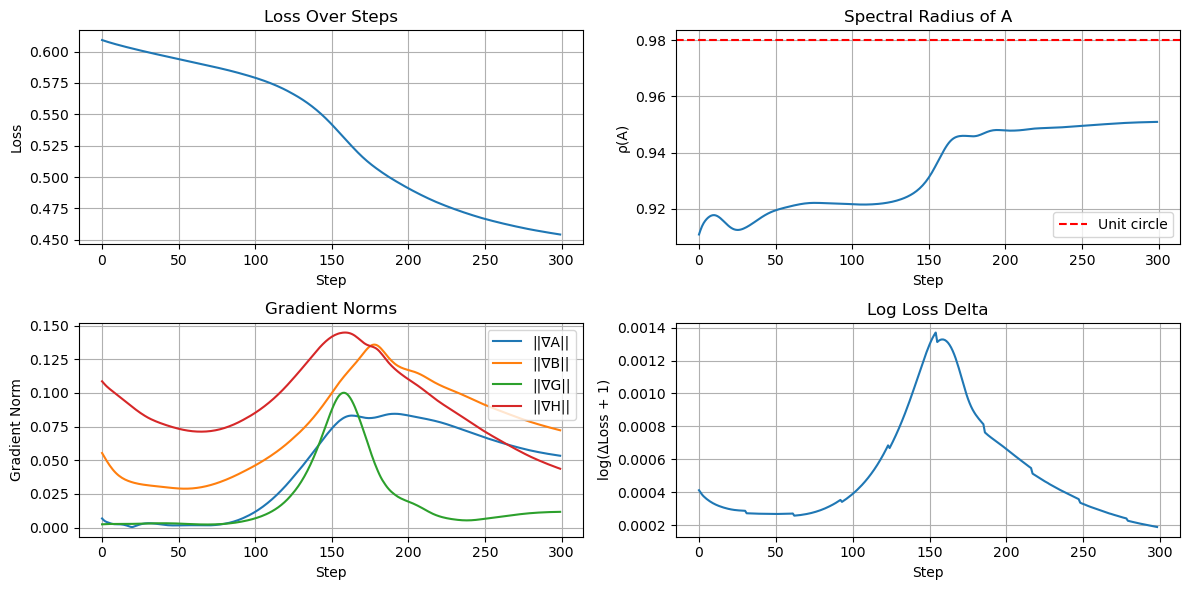


=== Optimizer Performance ===
Initial Learning Rate: 0.005, Decay Rate: 0.95


2025-05-07 16:18:09,299 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:18:09,736 - INFO - [Step 030] Loss: 0.565992
2025-05-07 16:18:10,167 - INFO - [Step 060] Loss: 0.461688
2025-05-07 16:18:10,672 - INFO - [Step 090] Loss: 0.435245
2025-05-07 16:18:11,089 - INFO - [Step 120] Loss: 0.427729
2025-05-07 16:18:11,509 - INFO - [Step 150] Loss: 0.424769
2025-05-07 16:18:12,083 - INFO - [Step 180] Loss: 0.423622
2025-05-07 16:18:12,514 - INFO - [Step 210] Loss: 0.422920
2025-05-07 16:18:12,931 - INFO - [Step 240] Loss: 0.422695
2025-05-07 16:18:13,381 - INFO - [Step 270] Loss: 0.422506
2025-05-07 16:18:13,952 - INFO - [Final Step 299] Loss: 0.422445


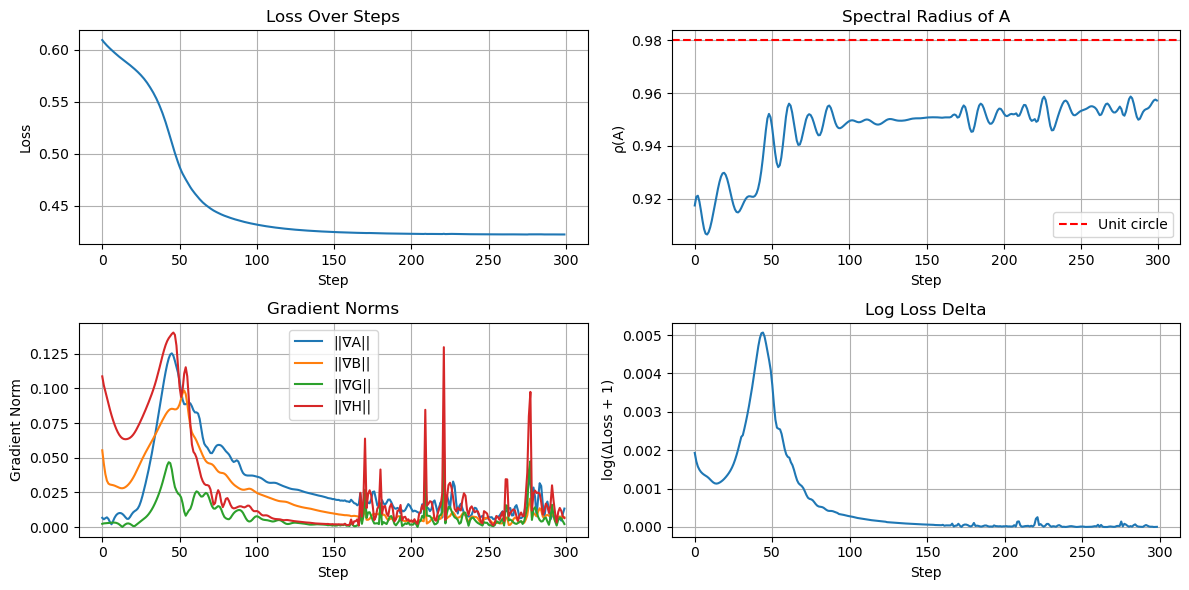


=== Optimizer Performance ===
Initial Learning Rate: 0.01, Decay Rate: 0.9


2025-05-07 16:18:15,433 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:18:15,867 - INFO - [Step 030] Loss: 0.481253
2025-05-07 16:18:16,288 - INFO - [Step 060] Loss: 0.433034
2025-05-07 16:18:16,705 - INFO - [Step 090] Loss: 0.425571
2025-05-07 16:18:17,130 - INFO - [Step 120] Loss: 0.423521
2025-05-07 16:18:17,572 - INFO - [Step 150] Loss: 0.625039
2025-05-07 16:18:18,001 - INFO - [Step 180] Loss: 0.599775
2025-05-07 16:18:18,418 - INFO - [Step 210] Loss: 0.554557
2025-05-07 16:18:18,838 - INFO - [Step 240] Loss: 0.537772
2025-05-07 16:18:19,262 - INFO - [Step 270] Loss: 0.524973
2025-05-07 16:18:19,667 - INFO - [Final Step 299] Loss: 0.515050


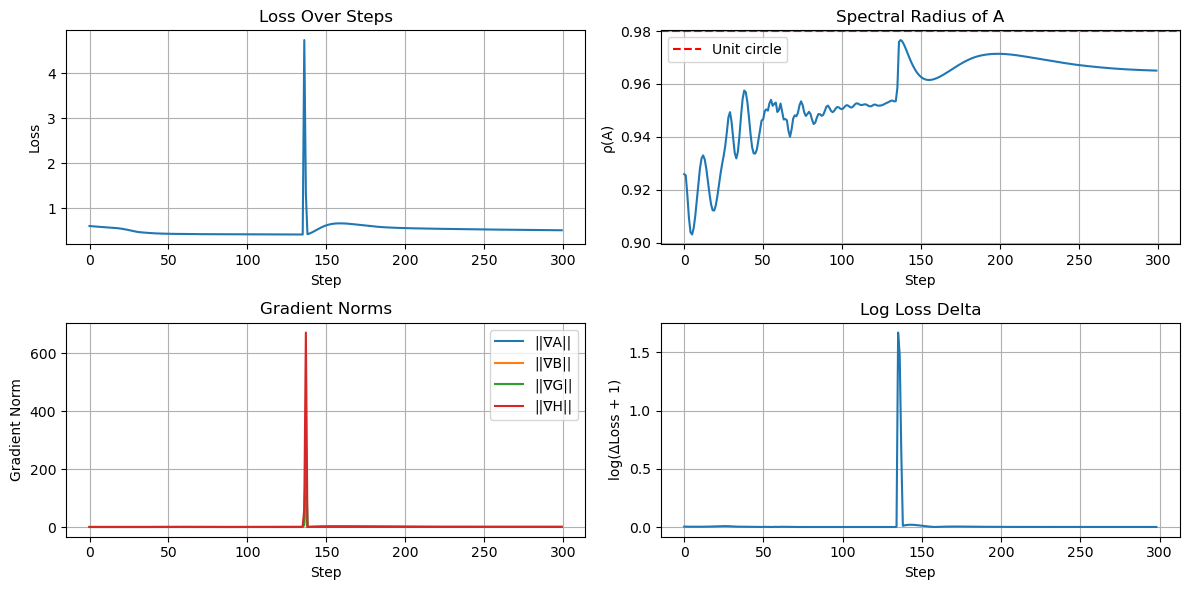

In [12]:
lr_decay_configs = [(1e-3, 0.95),  (5e-3, 0.95),  (1e-2, 0.9)]

Y = train_df_normalized.values
size = Y.shape[0]

for init_lr, decay in lr_decay_configs:
    print(f"\n=== Optimizer Performance ===")
    print(f"Initial Learning Rate: {init_lr}, Decay Rate: {decay}")

    lr_schedule = make_lr_schedule(init_lr, decay, size)
    optimizer = optax.adam(learning_rate=lr_schedule)

    train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = None, 
    max_horizon=1,
    label = 'Optimized One Step KF',
    optimizer = optimizer
    )

##### Choice of Optimizer

In practice, Adam works well enough for this setup.

It handles the imbalance in gradient magnitudes across parameters, and trains the model stably without needing much tuning. Since the Kalman filter has intertwined latent and observation dynamics, a naive optimizer like SGD tends to either under-train the latent space or blow up gradients in the observation path. Adam avoids this by adaptively scaling updates and smoothing out sharp transitions in the loss.

I did try variations like weight decay and multi-rate tuning, but none of them made a noticeable difference. Given the added complexity and sensitivity they introduce, I don’t think they’re worth using here.


### Topic Three - Curriculum Learning:

I experimented with curriculum learning as an alternative strategy to stabilize long-horizon optimization.

The idea is simple: rather than optimizing all horizons from the start, the model first learns to predict one-step ahead, then gradually increases the forecast horizon during training. This avoids overwhelming the model with noisy, compounding multi-step errors in the early stages and allows it to build stable latent dynamics first.

Empirically, I have a stepwise training pattern in loss curve, with clear loss drops when the horizon increases. The final loss decreased from around 0.24 (baseline without curriculum) to 0.20, indicating improved long-term prediction fit.

Gradient norms also reflect this process: they spike temporarily at each curriculum transition, then decay smoothly. These spikes align with the increase in forecast horizon, signaling adaptation to a harder task. Since the spikes are temporary, constrained, and followed by convergence, they indicate healthy optimization dynamics rather than instability.

**Takeaway**  
Curriculum learning improves convergence for multi-step objectives and eliminates the need for heavy regularization.

2025-05-07 16:18:44,996 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:18:45,576 - INFO - [Step 030] Loss: 0.565992
2025-05-07 16:18:46,032 - INFO - [Step 060] Loss: 0.461688
2025-05-07 16:18:47,474 - INFO - [Step 090] Loss: 0.358798
2025-05-07 16:18:47,918 - INFO - [Step 120] Loss: 0.347325
2025-05-07 16:18:49,706 - INFO - [Step 150] Loss: 0.266622
2025-05-07 16:18:50,162 - INFO - [Step 180] Loss: 0.263888
2025-05-07 16:18:50,607 - INFO - [Step 210] Loss: 0.263246
2025-05-07 16:18:52,036 - INFO - [Step 240] Loss: 0.201469
2025-05-07 16:18:52,477 - INFO - [Step 270] Loss: 0.200565
2025-05-07 16:18:52,895 - INFO - [Final Step 299] Loss: 0.200139


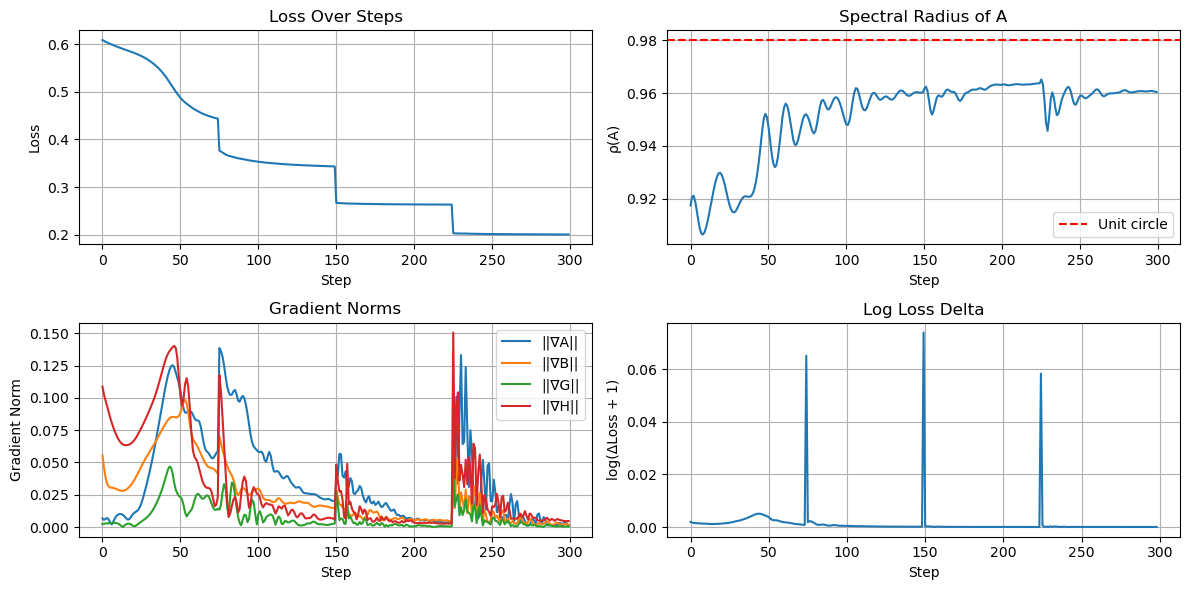

In [14]:
def curriculum_callback(step, config, max_horizon_target=4, horizon_step=75):
    new_horizon = min(1 + step // horizon_step, max_horizon_target)
    return KalmanFilterConfig(
        **{**config.__dict__, "max_horizon": new_horizon}
    )
train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = None,
    max_horizon=4,
    label = 'Optimized Four Step KF',
    config_callback=lambda step, cfg: curriculum_callback(step, cfg)
)

### Final Evaluation

We are going to compare optimzied KF model performance against that of initial KF and baseline model (PCA + VAR based regression).

#### One-Step-Ahead Forecast

After an exploration over regularization and learning rate, I decide to go ahead with Adam optimizer with moderate learning rate and no regularization.

2025-05-07 16:26:22,667 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:26:23,203 - INFO - [Step 030] Loss: 0.565992
2025-05-07 16:26:23,632 - INFO - [Step 060] Loss: 0.461688
2025-05-07 16:26:24,062 - INFO - [Step 090] Loss: 0.435245
2025-05-07 16:26:24,558 - INFO - [Step 120] Loss: 0.427729
2025-05-07 16:26:24,978 - INFO - [Step 150] Loss: 0.424769
2025-05-07 16:26:25,392 - INFO - [Step 180] Loss: 0.423622
2025-05-07 16:26:25,804 - INFO - [Step 210] Loss: 0.422920
2025-05-07 16:26:26,214 - INFO - [Step 240] Loss: 0.422695
2025-05-07 16:26:26,624 - INFO - [Step 270] Loss: 0.422506
2025-05-07 16:26:27,029 - INFO - [Final Step 299] Loss: 0.422445


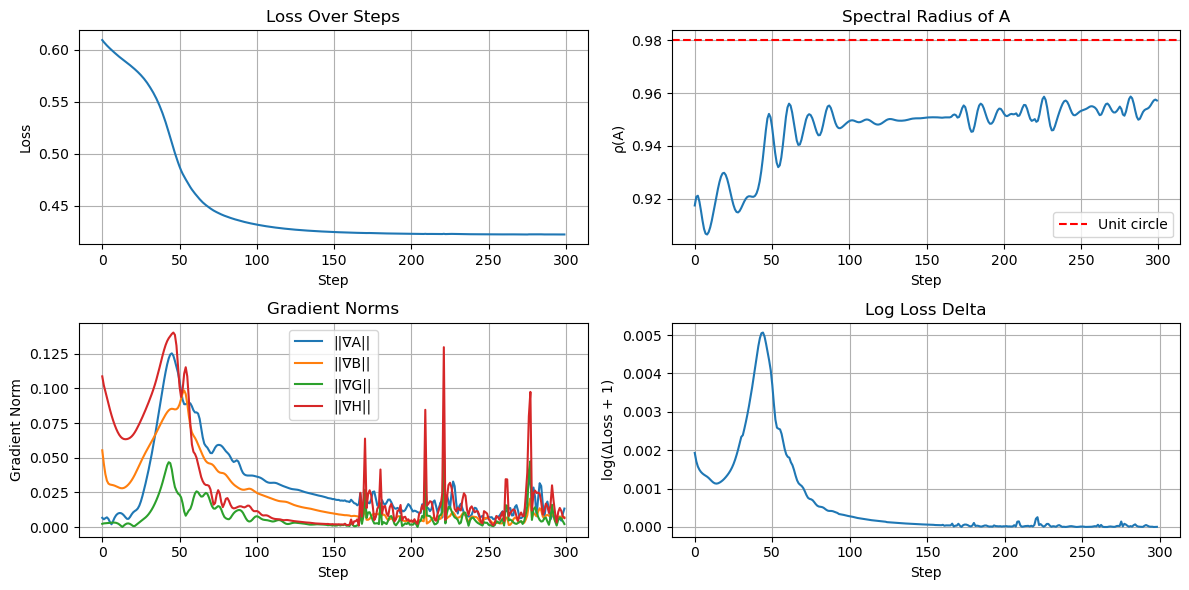

2025-05-07 16:26:28,089 - INFO - === Kalman Pipeline Evaluation ===
2025-05-07 16:26:28,090 - INFO - Step 1: Evaluating state estimate consistency...
2025-05-07 16:26:28,091 - INFO - Plotting state consistency...


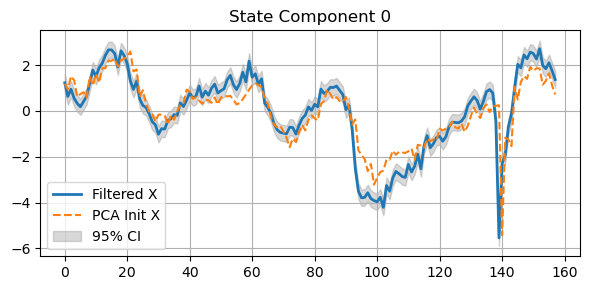

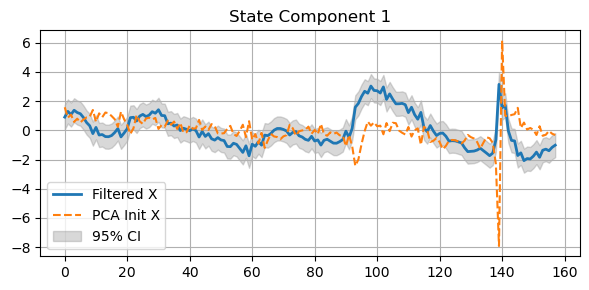

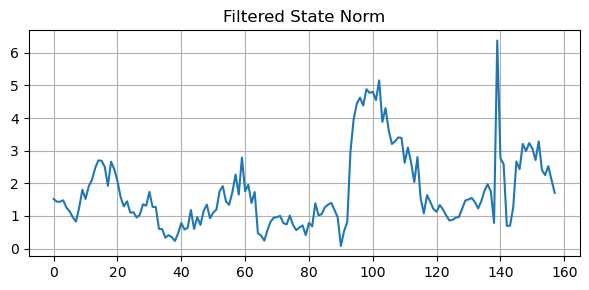

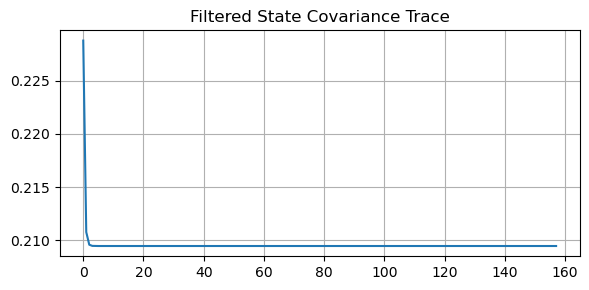

2025-05-07 16:26:29,218 - INFO - Step 2: Performing residual diagnostics...
2025-05-07 16:26:29,222 - INFO - Empirical Covariance between X_filt and Innovation:[[ 0.0331  0.047   0.0406  0.5928]
 [ 0.0129  0.0177  0.0233 -0.4118]]
2025-05-07 16:26:29,223 - WARNING - Max absolute cross-covariance (0.59280) exceeds tolerance (0.1) between X_filt and Innovation.
2025-05-07 16:26:29,226 - WARNING - Innovation[0] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:26:29,229 - WARNING - Innovation[1] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:26:29,248 - INFO - Innovation[2] Ljung-Box p=0.2174 — no autocorrelation
2025-05-07 16:26:29,258 - INFO - Innovation[3] Ljung-Box p=0.9530 — no autocorrelation


Plotting residual diagnostics for Innovation:


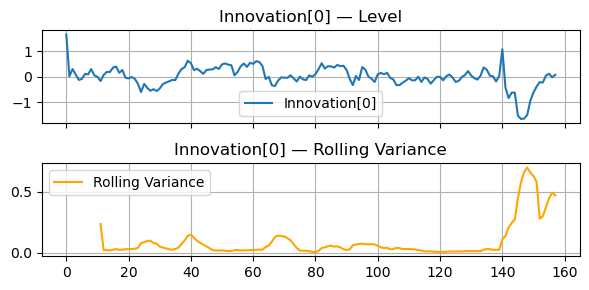

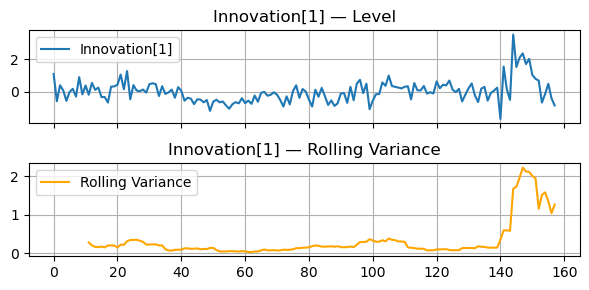

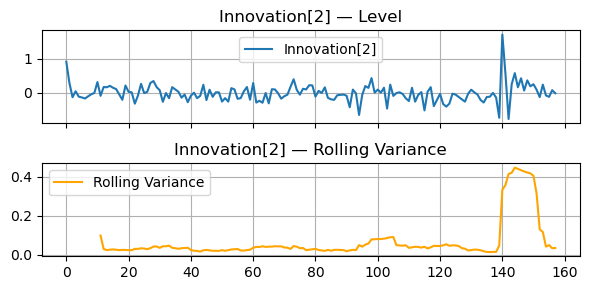

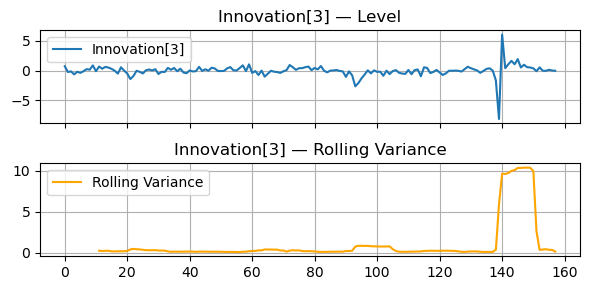

2025-05-07 16:26:30,960 - WARNING - Innovation mean not zero within tolerance 0.001: [ 0.0016  0.0017 -0.006  -0.0004]
2025-05-07 16:26:30,961 - INFO - Step 3: Evaluating multi-step forecast (with decay)...
2025-05-07 16:26:30,962 - INFO - Evaluating Optimized One Step KF forecast up to t+1 with decay γ=0.7


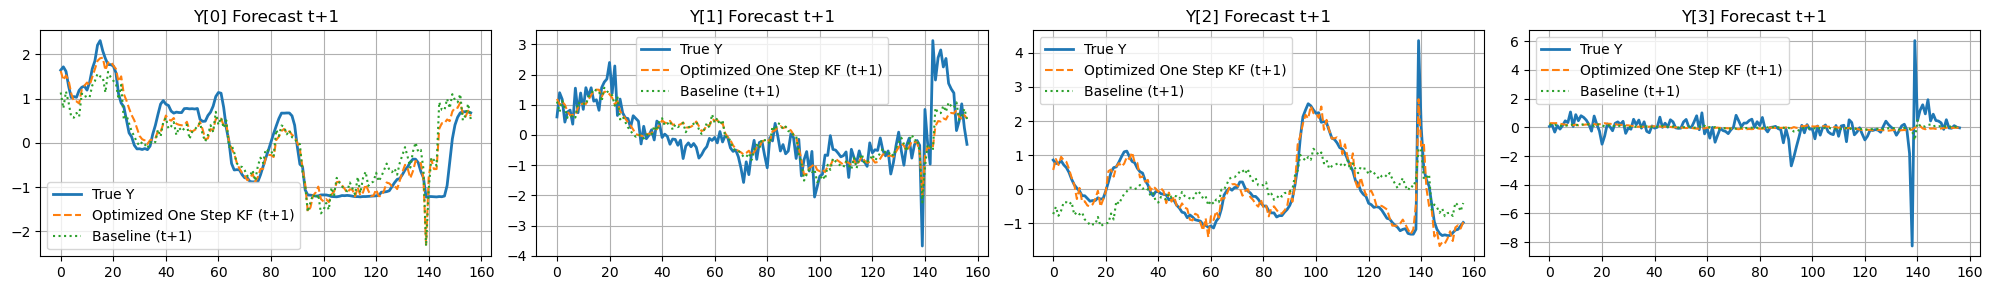

2025-05-07 16:26:32,049 - INFO - Total decay-weighted RMSE — Optimized One Step KF: 0.5852
2025-05-07 16:26:32,052 - INFO - Total decay-weighted RMSE — Baseline: 0.7588


In [18]:
one_step_rmse, one_step_metrics = train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = None,
    max_horizon = 1,
    label = 'Optimized One Step KF',
    post_eval = True
)

In [37]:
print(f"Optimized One-step-ahead KF total RMSE: {one_step_rmse:.4f} | Initial KF total RMSE: {initial_oneStep_rmse:.4f}")

one_step_full_comparison = pd.merge(one_step_metrics, initial_oneStep_metrics, on=['horizon', 'variable'])
one_step_full_comparison.sort_values(by=['Optimized One Step KF_rmse','Optimized One Step KF_r2'], ascending=[True, False])

Optimized One-step-ahead KF total RMSE: 0.5852 | Initial KF total RMSE: 0.7579


horizon variable  Optimized One Step KF_rmse  Optimized One Step KF_r2  \
2        1     Y[2]                    0.258333                  0.933329   
0        1     Y[0]                    0.398893                  0.839094   
1        1     Y[1]                    0.689480                  0.524013   
3        1     Y[3]                    0.994235                  0.014208   

   baseline_rmse  baseline_r2  Initial KF_rmse  Initial KF_r2  
2       0.845753     0.285398         0.847757       0.282008  
0       0.511889     0.735021         0.508382       0.738639  
1       0.672518     0.547145         0.670744       0.549531  
3       1.004974    -0.007202         1.004854      -0.006961

#### Four Step-Ahead Forecast

I decide to go ahead with Adam optimizer with moderate learning rate and curriculum training w/o regularization.

2025-05-07 16:28:10,779 - INFO - [Step 000] Loss: 0.609193
2025-05-07 16:28:11,232 - INFO - [Step 030] Loss: 0.565992
2025-05-07 16:28:11,735 - INFO - [Step 060] Loss: 0.461688
2025-05-07 16:28:12,904 - INFO - [Step 090] Loss: 0.358798
2025-05-07 16:28:13,501 - INFO - [Step 120] Loss: 0.347325
2025-05-07 16:28:15,004 - INFO - [Step 150] Loss: 0.266622
2025-05-07 16:28:15,465 - INFO - [Step 180] Loss: 0.263888
2025-05-07 16:28:16,096 - INFO - [Step 210] Loss: 0.263246
2025-05-07 16:28:17,672 - INFO - [Step 240] Loss: 0.201469
2025-05-07 16:28:18,269 - INFO - [Step 270] Loss: 0.200565
2025-05-07 16:28:18,740 - INFO - [Final Step 299] Loss: 0.200139


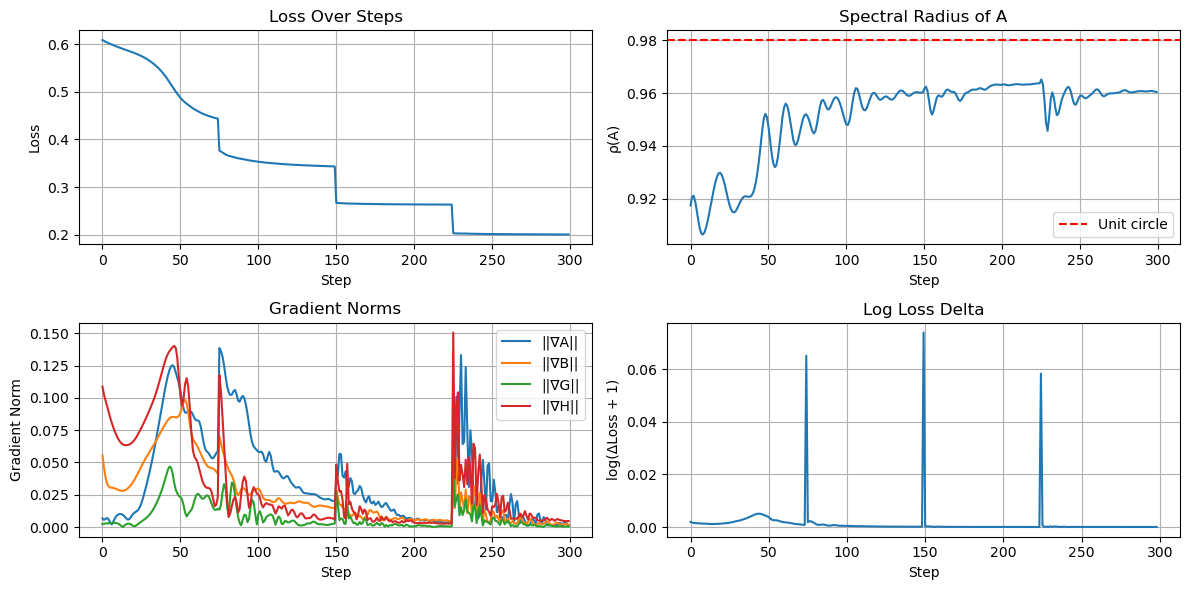

2025-05-07 16:28:20,033 - INFO - === Kalman Pipeline Evaluation ===
2025-05-07 16:28:20,034 - INFO - Step 1: Evaluating state estimate consistency...
2025-05-07 16:28:20,036 - INFO - Plotting state consistency...


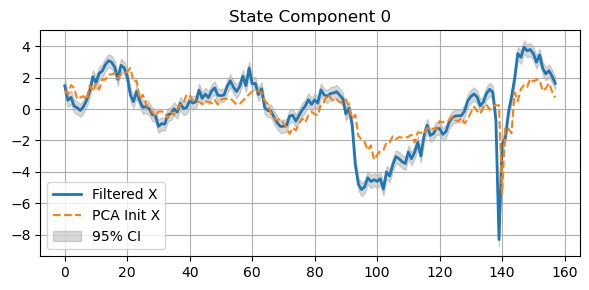

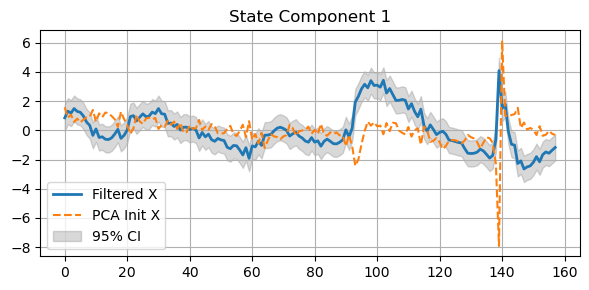

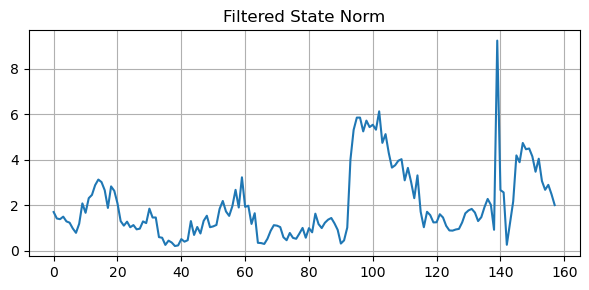

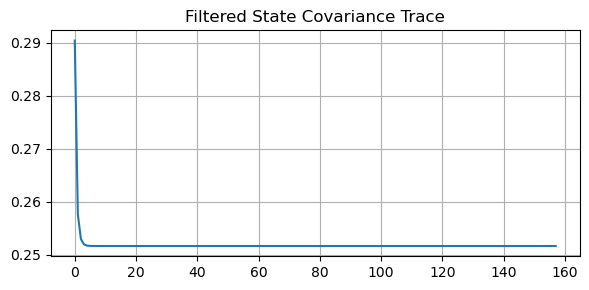

2025-05-07 16:28:21,218 - INFO - Step 2: Performing residual diagnostics...
2025-05-07 16:28:21,223 - INFO - Empirical Covariance between X_filt and Innovation:[[-0.3497  0.1492  0.167   0.9572]
 [ 0.2815 -0.0704 -0.0674 -0.5627]]
2025-05-07 16:28:21,224 - WARNING - Max absolute cross-covariance (0.95715) exceeds tolerance (0.1) between X_filt and Innovation.
2025-05-07 16:28:21,230 - WARNING - Innovation[0] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:28:21,248 - WARNING - Innovation[1] Ljung-Box p=0.0000 — autocorrelation exists
2025-05-07 16:28:21,270 - WARNING - Innovation[2] Ljung-Box p=0.0002 — autocorrelation exists
2025-05-07 16:28:21,275 - INFO - Innovation[3] Ljung-Box p=0.9477 — no autocorrelation


Plotting residual diagnostics for Innovation:


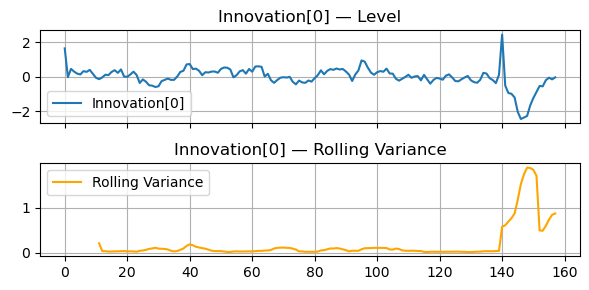

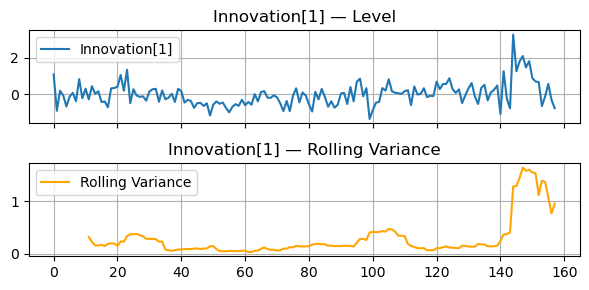

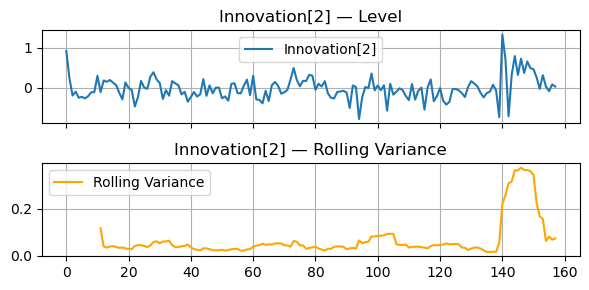

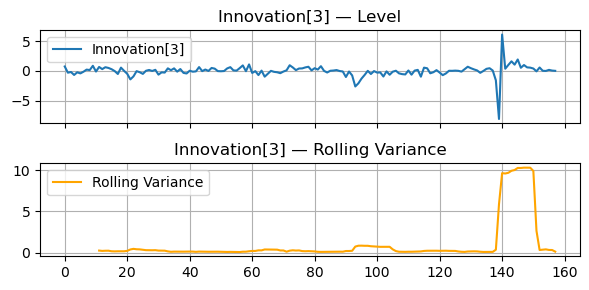

2025-05-07 16:28:23,060 - WARNING - Innovation mean not zero within tolerance 0.001: [ 0.0016  0.0003 -0.0067 -0.0009]
2025-05-07 16:28:23,061 - INFO - Step 3: Evaluating multi-step forecast (with decay)...
2025-05-07 16:28:23,063 - INFO - Evaluating Optimized Four Step KF forecast up to t+4 with decay γ=0.7


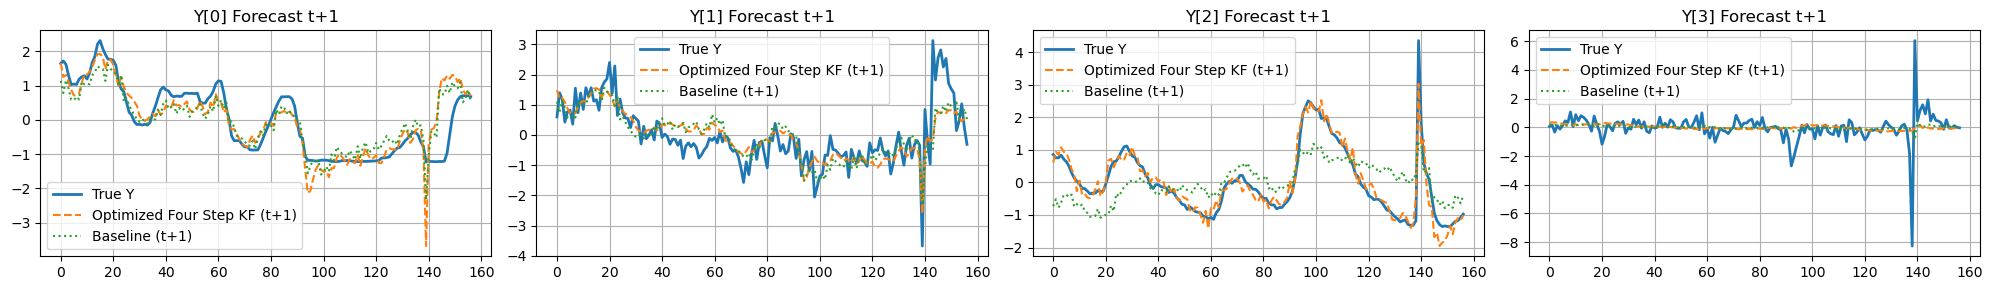

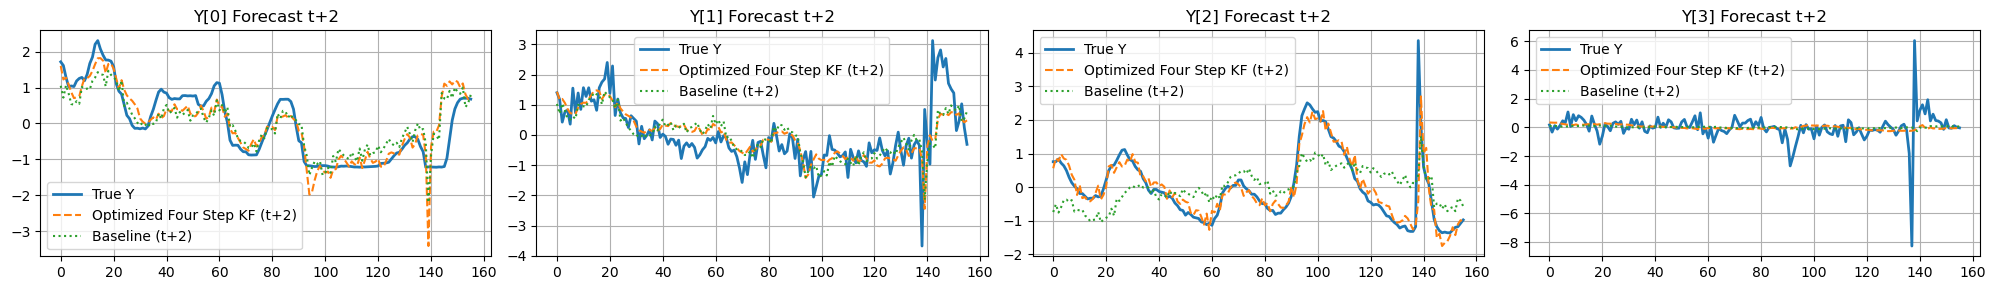

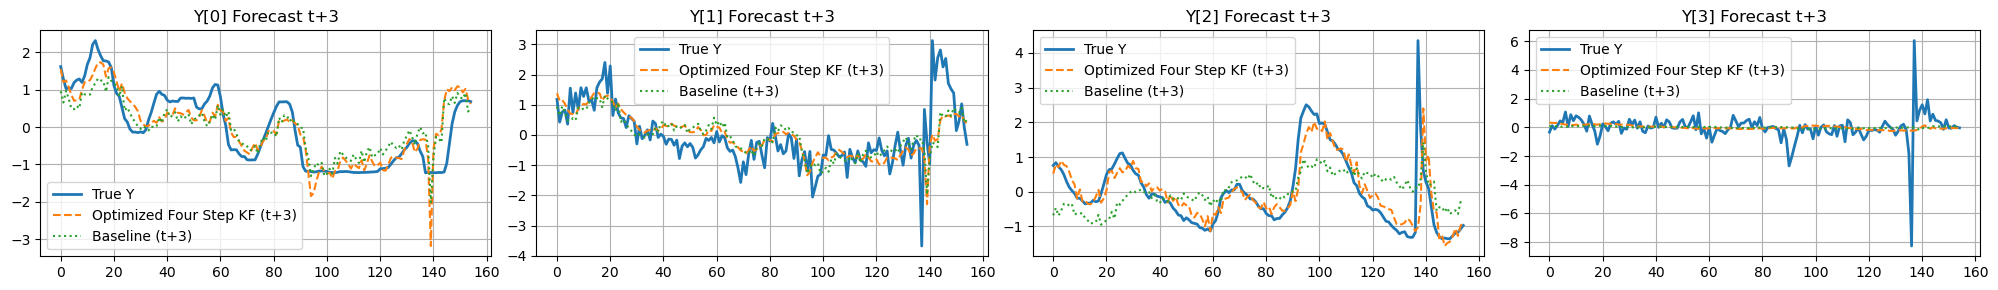

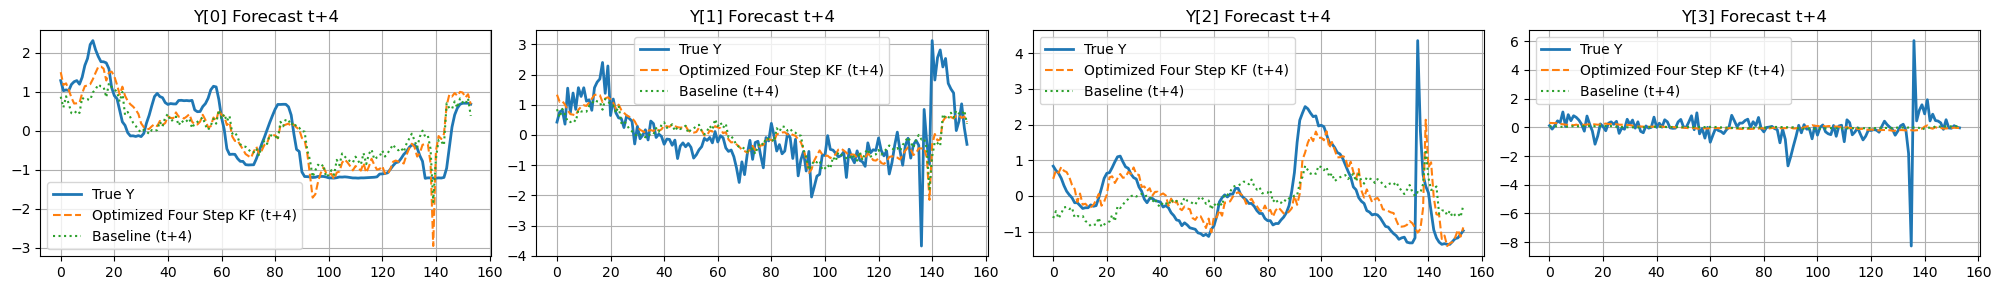

2025-05-07 16:28:30,364 - INFO - Total decay-weighted RMSE — Optimized Four Step KF: 1.6962
2025-05-07 16:28:30,367 - INFO - Total decay-weighted RMSE — Baseline: 1.9925


In [20]:
four_step_rmse, four_step_metrics = train_and_evaluate_kalman(
    Y=train_df_normalized.values,
    X_pca=train_latent_df,
    A=A, B=B, G_bar=G_bar, H_bar=H_bar,
    config = None,
    max_horizon=4,
    label = 'Optimized Four Step KF',
    config_callback=lambda step, cfg: curriculum_callback(step, cfg),
    post_eval = True
)

In [ ]:
print(f"Optimized Four-step-ahead KF total RMSE: {four_step_rmse:.4f} | Initial KF total RMSE: {initial_fourStep_rmse:.4f}")

four_step_full_comparison = pd.merge(four_step_metrics, initial_fourStep_metrics, on=['horizon', 'variable'])
display(four_step_full_comparison)

Optimized Four-step-ahead KF total RMSE: 1.6962 | Initial KF total RMSE: 1.9912


horizon variable  Optimized Four Step KF_rmse  Optimized Four Step KF_r2  \
0         1     Y[0]                     0.563528                   0.678863   
1         1     Y[1]                     0.634773                   0.596551   
2         1     Y[2]                     0.278509                   0.922508   
3         1     Y[3]                     0.993628                   0.015411   
4         2     Y[0]                     0.522281                   0.720960   
5         2     Y[1]                     0.729494                   0.469319   
6         2     Y[2]                     0.459435                   0.789464   
7         2     Y[3]                     0.998889                   0.011267   
8         3     Y[0]                     0.513381                   0.726661   
9         3     Y[1]                     0.740833                   0.449175   
10        3     Y[2]                     0.594509                   0.648396   
11        3     Y[3]                     1.001686                   0.011904   
12        4     Y[0]                     0.522445                   0.713505   
13        4     Y[1]                     0.758698                   0.420612   
14        4     Y[2]                     0.688292                   0.529944   
15        4     Y[3]                     1.005746                   0.009622   

    baseline_rmse  baseline_r2  Initial KF_rmse  Initial KF_r2  
0        0.511889     0.735021         0.508382       0.738639  
1        0.672518     0.547145         0.670744       0.549531  
2        0.845753     0.285398         0.847757       0.282008  
3        1.004974    -0.007202         1.004854      -0.006961  
4        0.514060     0.729676         0.512027       0.731810  
5        0.746389     0.444453         0.744596       0.447118  
6        0.887926     0.213622         0.889676       0.210519  
7        1.000996     0.007091         1.000971       0.007141  
8        0.539930     0.697660         0.538751       0.698979  
9        0.767115     0.409400         0.766724       0.410001  
10       0.922497     0.153424         0.923763       0.151098  
11       1.006125     0.003127         1.006153       0.003072  
12       0.574507     0.653561         0.573813       0.654397  
13       0.806541     0.345235         0.805835       0.346382  
14       0.945792     0.112445         0.947075       0.110035  
15       1.010891    -0.000536         1.010788      -0.000332

In [48]:
gamma = 0.7
df_decay = four_step_full_comparison.copy()
df_decay["decay_weight"] = gamma ** (df_decay["horizon"] - 1)
for col in ["Optimized Four Step KF_rmse", "baseline_rmse", "Initial KF_rmse"]:
    df_decay[f"{col}_weighted"] = df_decay[col] * df_decay["decay_weight"]

grouped = df_decay.groupby("variable").agg({
    "decay_weight": "sum",
    "Optimized Four Step KF_rmse_weighted": "sum",
    "baseline_rmse_weighted": "sum",
    "Initial KF_rmse_weighted": "sum"
})

for col in ["Optimized Four Step KF_rmse", "baseline_rmse", "Initial KF_rmse"]:
    grouped[col] = grouped[f"{col}_weighted"] / grouped["decay_weight"]

grouped[["Optimized Four Step KF_rmse", "baseline_rmse", "Initial KF_rmse"]].round(4).sort_values(by="Optimized Four Step KF_rmse", ascending=True)

Optimized Four Step KF_rmse  baseline_rmse  Initial KF_rmse
variable                                                             
Y[2]                           0.4451         0.8858           0.8875
Y[0]                           0.5369         0.5264           0.5241
Y[1]                           0.6982         0.7294           0.7280
Y[3]                           0.9983         1.0049           1.0048

Our optimized Kalman Filter significantly outperforms both baseline model (PCA + VAR) and Kalman Filter with initial parameters in terms of four step ahead prediction for CPI, unemployment rate, and GDP. Especially for unemployment rate, our model improves R2 from ~0.2 to ~0.9.

It's worth noting that our optimized model is better at predicting longer-term policy rate compared to short-term, indicating it may suffer from short-term fluctuation of federal adjustment.

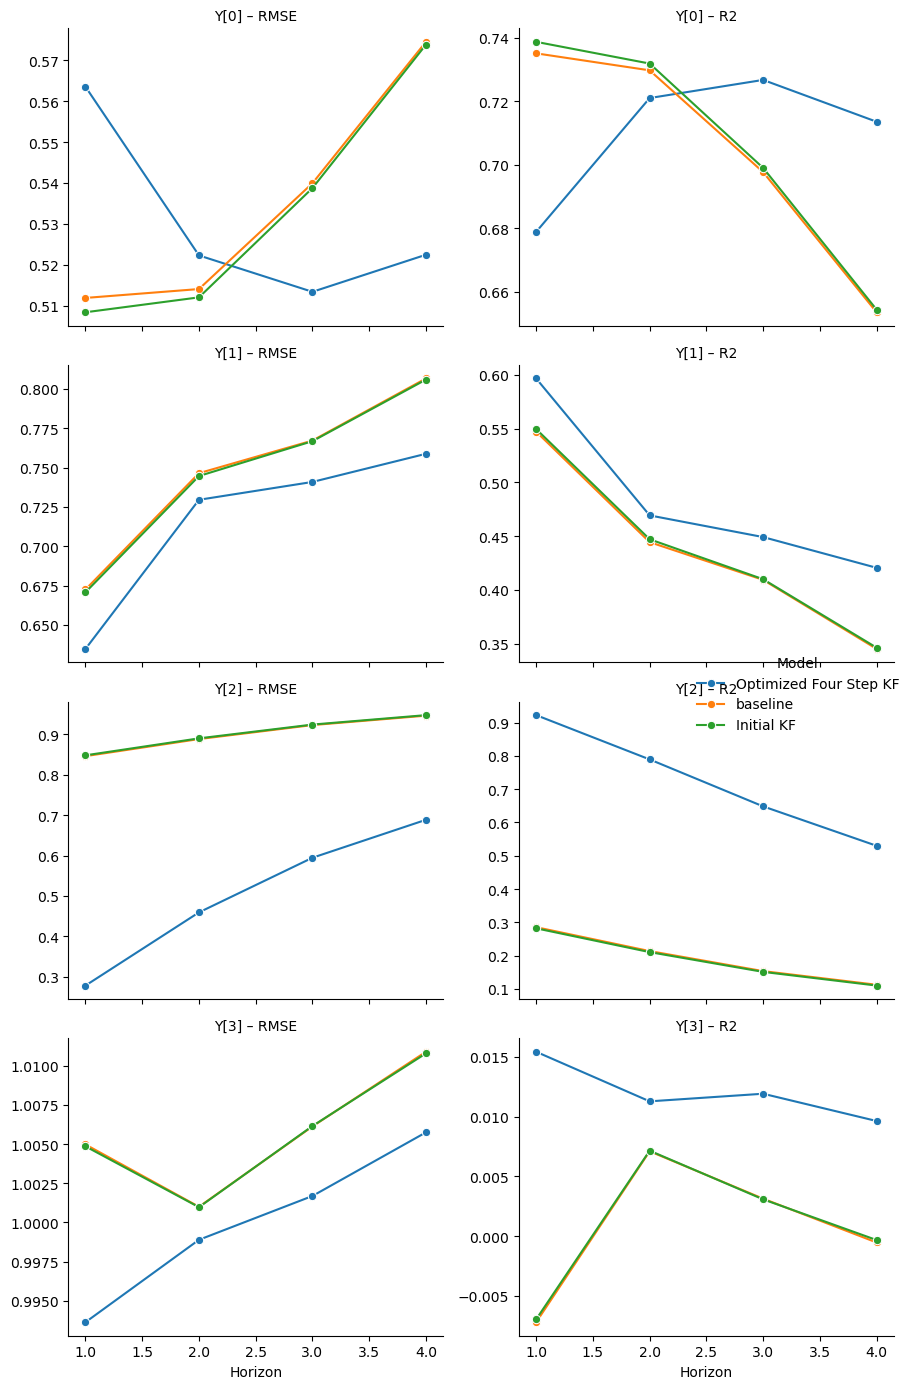

In [ ]:
# RMSE metrics
df_rmse = four_step_full_comparison.melt(
    id_vars=["horizon", "variable"],
    value_vars=[
        "Optimized Four Step KF_rmse", 
        "baseline_rmse", 
        "Initial KF_rmse"
    ],
    var_name="Model", value_name="Value"
)
df_rmse["Metric"] = "RMSE"

# R² metrics
df_r2 = four_step_full_comparison.melt(
    id_vars=["horizon", "variable"],
    value_vars=[
        "Optimized Four Step KF_r2", 
        "baseline_r2", 
        "Initial KF_r2"
    ],
    var_name="Model", value_name="Value"
)
df_r2["Metric"] = "R2"

df_long = pd.concat([df_rmse, df_r2], axis=0, ignore_index=True)
df_long["Model"] = df_long["Model"].str.replace("_rmse", "", regex=False)
df_long["Model"] = df_long["Model"].str.replace("_r2", "", regex=False)

g = sns.FacetGrid(df_long, col="Metric", row="variable", hue="Model", height=3.5, sharey=False)
g.map(sns.lineplot, "horizon", "Value", marker="o")
g.add_legend()
g.set_titles("{row_name} – {col_name}")
g.set_axis_labels("Horizon", "")
plt.tight_layout()
plt.show()